In [2]:
import pandas as pd
from sklearn.metrics import *
from tqdm import tqdm
from utils import HeteroDataProcessorFilterNode
import numpy as np

In [8]:

# Usage
file_path_replies = r"/home/azureuser/rumour-detection-pheme/replies_charlie_hebdo.pkl"
file_path_posts = r"/home/azureuser/rumour-detection-pheme/posts_charlie_hebdo.pkl"

time_cut =120

processor = HeteroDataProcessorFilterNode(file_path_replies, file_path_posts, time_cut)
data = processor.process()


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


In [4]:
data

HeteroData(
  id={
    x=[277, 106],
    y=[277],
    train_mask=[277],
    val_mask=[277],
    test_mask=[277],
  },
  reply_user_id={ x=[2137, 104] },
  (id, retweet, reply_user_id)={ edge_index=[2, 2137] },
  (reply_user_id, rev_retweet, id)={ edge_index=[2, 2137] }
)

In [24]:
import torch

def shuffle_heterodata(data):
    # Shuffle the 'id' node type
    perm = torch.randperm(data['id'].x.size(0))  # Generate a random permutation
    
    # Shuffle node features for 'id'
    data['id'].x = data['id'].x[perm]
    data['id'].y = data['id'].y[perm]
    data['id'].train_mask = data['id'].train_mask[perm]
    data['id'].val_mask = data['id'].val_mask[perm]
    data['id'].test_mask = data['id'].test_mask[perm]
    
    # Adjust edge indices for the relations involving 'id' nodes
    data[('id', 'retweet', 'reply_user_id')].edge_index[0] = perm[data[('id', 'retweet', 'reply_user_id')].edge_index[0]]
    data[('reply_user_id', 'rev_retweet', 'id')].edge_index[1] = perm[data[('reply_user_id', 'rev_retweet', 'id')].edge_index[1]]
    
    return data

# Assuming 'data' is your HeteroData object
data = shuffle_heterodata(data)


In [9]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
#mlflow.set_experiment("spyder-experiment")
import mlflow.pytorch
mlflow.set_experiment("GAT Network 2024-09-24 Filter Node")

2024/09/25 01:11:11 INFO mlflow.tracking.fluent: Experiment with name 'GAT Network 2024-09-24 Filter Node' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/azureuser/rumour-detection-pheme/mlruns/20', creation_time=1727226671698, experiment_id='20', last_update_time=1727226671698, lifecycle_stage='active', name='GAT Network 2024-09-24 Filter Node', tags={}>

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, to_hetero

class GAT(torch.nn.Module):
    def __init__(self, dim_h, dim_out):
        super().__init__()
        self.conv1 = GATConv((-1, -1), dim_h, add_self_loops=False)
        self.conv2 = GATConv(dim_h, dim_h, add_self_loops=False)  # Added second GATConv layer
        self.linear = nn.Linear(dim_h, dim_out)
        self.dropout = nn.Dropout(p=0.4)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index).relu()
        h = self.dropout(h)
        h = self.conv2(h, edge_index).relu()  # Pass through the second GATConv layer
        h = self.dropout(h)
        h = self.linear(h)
        return h

@torch.no_grad()
def test(mask):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict)['id'].argmax(dim=-1)
    acc = (pred[mask] == data['id'].y[mask]).sum() / mask.sum()
    return float(acc)

In [11]:

model = GAT(dim_h=64, dim_out=2)
model = to_hetero(model, data.metadata(), aggr='sum')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data, model = data.to(device), model.to(device)



for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)['id']
    mask = data['id'].train_mask
    loss = F.cross_entropy(out[mask], data['id'].y[mask])
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        train_acc = test(data['id'].train_mask)
        val_acc = test(data['id'].val_mask)
        print(f'Epoch: {epoch:>3} | Train Loss: {loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%')
    
test_acc = test(data['id'].test_mask)
print(f'Test accuracy: {test_acc*100:.2f}%')
    


Epoch:   0 | Train Loss: 0.6830 | Train Acc: 64.77% | Val Acc: 53.66%
Epoch:  50 | Train Loss: 0.3573 | Train Acc: 84.97% | Val Acc: 87.80%
Epoch: 100 | Train Loss: 0.1564 | Train Acc: 96.37% | Val Acc: 92.68%
Epoch: 150 | Train Loss: 0.0381 | Train Acc: 100.00% | Val Acc: 90.24%
Epoch: 200 | Train Loss: 0.0107 | Train Acc: 100.00% | Val Acc: 92.68%
Epoch: 250 | Train Loss: 0.0051 | Train Acc: 100.00% | Val Acc: 90.24%
Epoch: 300 | Train Loss: 0.0054 | Train Acc: 100.00% | Val Acc: 90.24%
Epoch: 350 | Train Loss: 0.0047 | Train Acc: 100.00% | Val Acc: 92.68%
Epoch: 400 | Train Loss: 0.0060 | Train Acc: 100.00% | Val Acc: 87.80%
Epoch: 450 | Train Loss: 0.0019 | Train Acc: 100.00% | Val Acc: 90.24%
Test accuracy: 86.05%


In [6]:
test_mask = data['id'].test_mask | data['id'].val_mask
pred = model(data.x_dict, data.edge_index_dict)['id'].argmax(dim=-1)
true_labels = data['id'].y[test_mask]
pred_labels = pred[test_mask]
precision_score(true_labels, pred_labels, average='macro')

0.8723529411764706

In [7]:
recall_score(true_labels, pred_labels, average='macro')

0.9113060428849902

In [8]:
input_example = data.x_dict, data.edge_index_dict

In [ ]:
#
file_path_replies = r"/home/azureuser/rumour-detection-pheme/replies_charlie_hebdo.pkl"
file_path_posts = r"/home/azureuser/rumour-detection-pheme/posts_charlie_hebdo.pkl"

for time_cut in range(17,48*60,10):
    print(time_cut)
    processor = HeteroDataProcessorFilterNode(file_path_replies, file_path_posts, time_cut)
    data = processor.process()

    model = GAT(dim_h=64, dim_out=2)
    model = to_hetero(model, data.metadata(), aggr='sum')
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data, model = data.to(device), model.to(device)
   
    with mlflow.start_run():

        for epoch in range(400):
            model.train()
            optimizer.zero_grad()
            out = model(data.x_dict, data.edge_index_dict)['id']
            mask = data['id'].train_mask
            loss = F.cross_entropy(out[mask], data['id'].y[mask])
            loss.backward()
            optimizer.step()
            
            if epoch % 100 == 0:
                print(epoch)
                train_acc = test(data['id'].train_mask)
                val_acc = test(data['id'].val_mask)
                print(f'Epoch: {epoch:>3} | Train Loss: {loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%')

            
        test_acc = test(data['id'].test_mask)
        print(f'Test accuracy: {test_acc*100:.2f}%')

        test_mask = data['id'].test_mask | data['id'].val_mask
        pred = model(data.x_dict, data.edge_index_dict)['id'].argmax(dim=-1)
        true_labels = data['id'].y[test_mask]
        pred_labels = pred[test_mask]
        test_precision =precision_score(true_labels, pred_labels, average='macro')
        test_recall=recall_score(true_labels, pred_labels, average='macro')
        print(f'Test Recall: {test_recall*100:.2f}%')
        print(f'Test Precision: {test_precision*100:.2f}%')

        mlflow.log_metric("train_loss", loss.item(), step=epoch)
        mlflow.log_metric("train_acc", train_acc, step=epoch)
        mlflow.log_metric("val_acc", val_acc, step=epoch)
        mlflow.log_metric("test_acc", test_acc)
        mlflow.log_metric("test_precision",  test_precision)
        mlflow.log_metric("test_recall",  test_recall)

            
        mlflow.log_param("dim_h", 64)
        mlflow.log_param("dim_out", 2)
        mlflow.log_param("learning_rate", 0.001)
        mlflow.log_param("epochs", 400)
        mlflow.log_metric("time_cut", time_cut)



        
            
        mlflow.pytorch.log_model(model, f"GAT_model_{time_cut}")


17


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7330 | Train Acc: 56.25% | Val Acc: 33.33%
100
Epoch: 100 | Train Loss: 0.0072 | Train Acc: 100.00% | Val Acc: 66.67%
200
Epoch: 200 | Train Loss: 0.0010 | Train Acc: 100.00% | Val Acc: 66.67%
300
Epoch: 300 | Train Loss: 0.0009 | Train Acc: 100.00% | Val Acc: 66.67%
Test accuracy: 75.00%
Test Recall: 66.67%
Test Precision: 83.33%


2024/09/25 01:12:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


27


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7295 | Train Acc: 51.61% | Val Acc: 33.33%
100
Epoch: 100 | Train Loss: 0.0283 | Train Acc: 100.00% | Val Acc: 66.67%
200
Epoch: 200 | Train Loss: 0.0049 | Train Acc: 100.00% | Val Acc: 66.67%
300
Epoch: 300 | Train Loss: 0.0006 | Train Acc: 100.00% | Val Acc: 66.67%
Test accuracy: 87.50%
Test Recall: 77.08%
Test Precision: 78.89%


2024/09/25 01:12:16 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


37


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7463 | Train Acc: 46.94% | Val Acc: 40.00%
100
Epoch: 100 | Train Loss: 0.0547 | Train Acc: 100.00% | Val Acc: 80.00%
200
Epoch: 200 | Train Loss: 0.0025 | Train Acc: 100.00% | Val Acc: 80.00%
300
Epoch: 300 | Train Loss: 0.0010 | Train Acc: 100.00% | Val Acc: 80.00%
Test accuracy: 66.67%
Test Recall: 74.17%
Test Precision: 75.89%


2024/09/25 01:12:25 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


47


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6717 | Train Acc: 67.21% | Val Acc: 46.15%
100
Epoch: 100 | Train Loss: 0.0937 | Train Acc: 100.00% | Val Acc: 92.31%
200
Epoch: 200 | Train Loss: 0.0045 | Train Acc: 100.00% | Val Acc: 92.31%
300
Epoch: 300 | Train Loss: 0.0023 | Train Acc: 100.00% | Val Acc: 92.31%
Test accuracy: 92.86%
Test Recall: 89.29%
Test Precision: 90.62%


2024/09/25 01:12:37 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


57


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6934 | Train Acc: 68.92% | Val Acc: 62.50%
100
Epoch: 100 | Train Loss: 0.0835 | Train Acc: 100.00% | Val Acc: 93.75%
200
Epoch: 200 | Train Loss: 0.0175 | Train Acc: 100.00% | Val Acc: 93.75%
300
Epoch: 300 | Train Loss: 0.0019 | Train Acc: 100.00% | Val Acc: 93.75%
Test accuracy: 76.47%
Test Recall: 84.56%
Test Precision: 86.15%


2024/09/25 01:12:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


67


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7101 | Train Acc: 62.07% | Val Acc: 66.67%
100
Epoch: 100 | Train Loss: 0.0870 | Train Acc: 97.70% | Val Acc: 83.33%
200
Epoch: 200 | Train Loss: 0.0154 | Train Acc: 100.00% | Val Acc: 83.33%
300
Epoch: 300 | Train Loss: 0.0053 | Train Acc: 100.00% | Val Acc: 83.33%
Test accuracy: 80.00%
Test Recall: 81.67%
Test Precision: 81.58%


2024/09/25 01:12:55 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


77


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7406 | Train Acc: 50.49% | Val Acc: 59.09%
100
Epoch: 100 | Train Loss: 0.0985 | Train Acc: 100.00% | Val Acc: 77.27%
200
Epoch: 200 | Train Loss: 0.0098 | Train Acc: 100.00% | Val Acc: 77.27%
300
Epoch: 300 | Train Loss: 0.0028 | Train Acc: 100.00% | Val Acc: 77.27%
Test accuracy: 95.65%
Test Recall: 85.50%
Test Precision: 88.25%


2024/09/25 01:13:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


87


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6959 | Train Acc: 52.94% | Val Acc: 60.00%
100
Epoch: 100 | Train Loss: 0.0831 | Train Acc: 98.32% | Val Acc: 88.00%
200
Epoch: 200 | Train Loss: 0.0089 | Train Acc: 100.00% | Val Acc: 92.00%
300
Epoch: 300 | Train Loss: 0.0027 | Train Acc: 100.00% | Val Acc: 88.00%
Test accuracy: 88.89%
Test Recall: 92.19%
Test Precision: 90.00%


2024/09/25 01:13:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


97


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7351 | Train Acc: 46.94% | Val Acc: 45.16%
100
Epoch: 100 | Train Loss: 0.1367 | Train Acc: 98.64% | Val Acc: 90.32%
200
Epoch: 200 | Train Loss: 0.0160 | Train Acc: 100.00% | Val Acc: 90.32%
300
Epoch: 300 | Train Loss: 0.0042 | Train Acc: 100.00% | Val Acc: 90.32%
Test accuracy: 87.50%
Test Recall: 89.35%
Test Precision: 88.64%


2024/09/25 01:13:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


107


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6921 | Train Acc: 57.58% | Val Acc: 45.71%
100
Epoch: 100 | Train Loss: 0.1332 | Train Acc: 96.97% | Val Acc: 77.14%
200
Epoch: 200 | Train Loss: 0.0203 | Train Acc: 100.00% | Val Acc: 88.57%
300
Epoch: 300 | Train Loss: 0.0139 | Train Acc: 100.00% | Val Acc: 88.57%
Test accuracy: 88.89%
Test Recall: 88.68%
Test Precision: 88.68%


2024/09/25 01:13:33 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


117


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7162 | Train Acc: 55.61% | Val Acc: 55.00%
100
Epoch: 100 | Train Loss: 0.1130 | Train Acc: 96.79% | Val Acc: 90.00%
200
Epoch: 200 | Train Loss: 0.0138 | Train Acc: 100.00% | Val Acc: 92.50%
300
Epoch: 300 | Train Loss: 0.0086 | Train Acc: 100.00% | Val Acc: 92.50%
Test accuracy: 90.24%
Test Recall: 92.51%
Test Precision: 90.11%


2024/09/25 01:13:43 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


127


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6834 | Train Acc: 69.95% | Val Acc: 68.89%
100
Epoch: 100 | Train Loss: 0.1433 | Train Acc: 96.71% | Val Acc: 88.89%
200
Epoch: 200 | Train Loss: 0.0139 | Train Acc: 99.53% | Val Acc: 93.33%
300
Epoch: 300 | Train Loss: 0.0071 | Train Acc: 100.00% | Val Acc: 93.33%
Test accuracy: 87.23%
Test Recall: 90.16%
Test Precision: 88.37%


2024/09/25 01:13:53 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


137


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7188 | Train Acc: 52.08% | Val Acc: 52.94%
100
Epoch: 100 | Train Loss: 0.1383 | Train Acc: 95.83% | Val Acc: 88.24%
200
Epoch: 200 | Train Loss: 0.0272 | Train Acc: 99.58% | Val Acc: 92.16%
300
Epoch: 300 | Train Loss: 0.0055 | Train Acc: 100.00% | Val Acc: 94.12%
Test accuracy: 88.68%
Test Recall: 90.28%
Test Precision: 89.61%


2024/09/25 01:14:03 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


147


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7752 | Train Acc: 54.05% | Val Acc: 52.73%
100
Epoch: 100 | Train Loss: 0.1722 | Train Acc: 95.75% | Val Acc: 89.09%
200
Epoch: 200 | Train Loss: 0.0180 | Train Acc: 100.00% | Val Acc: 96.36%
300
Epoch: 300 | Train Loss: 0.0063 | Train Acc: 100.00% | Val Acc: 96.36%
Test accuracy: 85.96%
Test Recall: 84.23%
Test Precision: 87.66%


2024/09/25 01:14:19 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


157


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8469 | Train Acc: 69.34% | Val Acc: 68.85%
100
Epoch: 100 | Train Loss: 0.1330 | Train Acc: 96.52% | Val Acc: 90.16%
200
Epoch: 200 | Train Loss: 0.0240 | Train Acc: 99.65% | Val Acc: 91.80%
300
Epoch: 300 | Train Loss: 0.0225 | Train Acc: 100.00% | Val Acc: 91.80%
Test accuracy: 82.54%
Test Recall: 83.21%
Test Precision: 84.45%


2024/09/25 01:14:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


167


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7141 | Train Acc: 59.09% | Val Acc: 63.64%
100
Epoch: 100 | Train Loss: 0.1728 | Train Acc: 95.78% | Val Acc: 84.85%
200
Epoch: 200 | Train Loss: 0.0350 | Train Acc: 100.00% | Val Acc: 83.33%
300
Epoch: 300 | Train Loss: 0.0080 | Train Acc: 100.00% | Val Acc: 83.33%
Test accuracy: 88.06%
Test Recall: 84.27%
Test Precision: 83.01%


2024/09/25 01:14:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


177


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6487 | Train Acc: 72.78% | Val Acc: 74.29%
100
Epoch: 100 | Train Loss: 0.1780 | Train Acc: 94.19% | Val Acc: 92.86%
200
Epoch: 200 | Train Loss: 0.0544 | Train Acc: 100.00% | Val Acc: 92.86%
300
Epoch: 300 | Train Loss: 0.0113 | Train Acc: 100.00% | Val Acc: 92.86%
Test accuracy: 85.92%
Test Recall: 85.56%
Test Precision: 86.23%


2024/09/25 01:15:07 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


187


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6832 | Train Acc: 58.81% | Val Acc: 57.33%
100
Epoch: 100 | Train Loss: 0.2195 | Train Acc: 93.18% | Val Acc: 93.33%
200
Epoch: 200 | Train Loss: 0.0623 | Train Acc: 99.43% | Val Acc: 94.67%
300
Epoch: 300 | Train Loss: 0.0165 | Train Acc: 100.00% | Val Acc: 93.33%
Test accuracy: 89.47%
Test Recall: 87.11%
Test Precision: 86.21%


2024/09/25 01:15:19 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


197


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8218 | Train Acc: 24.54% | Val Acc: 30.86%
100
Epoch: 100 | Train Loss: 0.2381 | Train Acc: 89.45% | Val Acc: 87.65%
200
Epoch: 200 | Train Loss: 0.0761 | Train Acc: 97.63% | Val Acc: 92.59%
300
Epoch: 300 | Train Loss: 0.0195 | Train Acc: 99.74% | Val Acc: 90.12%
Test accuracy: 89.02%
Test Recall: 83.72%
Test Precision: 86.18%


2024/09/25 01:15:32 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


207


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6805 | Train Acc: 76.35% | Val Acc: 71.26%
100
Epoch: 100 | Train Loss: 0.1672 | Train Acc: 94.09% | Val Acc: 83.91%
200
Epoch: 200 | Train Loss: 0.0487 | Train Acc: 99.01% | Val Acc: 83.91%
300
Epoch: 300 | Train Loss: 0.0085 | Train Acc: 100.00% | Val Acc: 85.06%
Test accuracy: 90.91%
Test Recall: 89.22%
Test Precision: 83.53%


2024/09/25 01:15:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


217


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7628 | Train Acc: 62.21% | Val Acc: 60.22%
100
Epoch: 100 | Train Loss: 0.2075 | Train Acc: 94.24% | Val Acc: 87.10%
200
Epoch: 200 | Train Loss: 0.0712 | Train Acc: 98.39% | Val Acc: 83.87%
300
Epoch: 300 | Train Loss: 0.0182 | Train Acc: 99.77% | Val Acc: 82.80%
Test accuracy: 88.30%
Test Recall: 82.75%
Test Precision: 79.57%


2024/09/25 01:15:58 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


227


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6859 | Train Acc: 73.09% | Val Acc: 72.16%
100
Epoch: 100 | Train Loss: 0.1678 | Train Acc: 96.06% | Val Acc: 83.51%
200
Epoch: 200 | Train Loss: 0.0530 | Train Acc: 99.12% | Val Acc: 82.47%
300
Epoch: 300 | Train Loss: 0.0198 | Train Acc: 99.78% | Val Acc: 83.51%
Test accuracy: 88.89%
Test Recall: 80.48%
Test Precision: 77.47%


2024/09/25 01:16:12 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


237


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6791 | Train Acc: 77.73% | Val Acc: 78.43%
100
Epoch: 100 | Train Loss: 0.1764 | Train Acc: 94.33% | Val Acc: 86.27%
200
Epoch: 200 | Train Loss: 0.0688 | Train Acc: 98.74% | Val Acc: 88.24%
300
Epoch: 300 | Train Loss: 0.0173 | Train Acc: 100.00% | Val Acc: 89.22%
Test accuracy: 92.23%
Test Recall: 85.02%
Test Precision: 82.75%


2024/09/25 01:16:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


247


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7310 | Train Acc: 39.76% | Val Acc: 41.90%
100
Epoch: 100 | Train Loss: 0.2098 | Train Acc: 92.90% | Val Acc: 84.76%
200
Epoch: 200 | Train Loss: 0.0897 | Train Acc: 97.77% | Val Acc: 88.57%
300
Epoch: 300 | Train Loss: 0.0248 | Train Acc: 99.59% | Val Acc: 89.52%
Test accuracy: 89.72%
Test Recall: 80.76%
Test Precision: 83.13%


2024/09/25 01:16:43 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


257


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.0063 | Train Acc: 18.32% | Val Acc: 17.43%
100
Epoch: 100 | Train Loss: 0.2342 | Train Acc: 90.25% | Val Acc: 90.83%
200
Epoch: 200 | Train Loss: 0.0975 | Train Acc: 97.27% | Val Acc: 90.83%
300
Epoch: 300 | Train Loss: 0.0508 | Train Acc: 98.83% | Val Acc: 92.66%
Test accuracy: 89.19%
Test Recall: 86.96%
Test Precision: 85.35%


2024/09/25 01:16:58 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


267


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7527 | Train Acc: 72.18% | Val Acc: 77.19%
100
Epoch: 100 | Train Loss: 0.2093 | Train Acc: 93.61% | Val Acc: 90.35%
200
Epoch: 200 | Train Loss: 0.0904 | Train Acc: 97.37% | Val Acc: 90.35%
300
Epoch: 300 | Train Loss: 0.0260 | Train Acc: 99.81% | Val Acc: 92.11%
Test accuracy: 86.96%
Test Recall: 81.39%
Test Precision: 83.80%


2024/09/25 01:17:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


277


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8142 | Train Acc: 76.15% | Val Acc: 75.86%
100
Epoch: 100 | Train Loss: 0.2217 | Train Acc: 92.48% | Val Acc: 91.38%
200
Epoch: 200 | Train Loss: 0.1073 | Train Acc: 97.61% | Val Acc: 92.24%
300
Epoch: 300 | Train Loss: 0.0632 | Train Acc: 99.08% | Val Acc: 93.10%
Test accuracy: 92.37%
Test Recall: 91.05%
Test Precision: 86.96%


2024/09/25 01:17:29 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


287


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8251 | Train Acc: 26.97% | Val Acc: 32.76%
100
Epoch: 100 | Train Loss: 0.2112 | Train Acc: 91.19% | Val Acc: 81.03%
200
Epoch: 200 | Train Loss: 0.1105 | Train Acc: 97.80% | Val Acc: 87.07%
300
Epoch: 300 | Train Loss: 0.0503 | Train Acc: 98.90% | Val Acc: 89.66%
Test accuracy: 89.83%
Test Recall: 79.73%
Test Precision: 87.26%


2024/09/25 01:17:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


297


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6952 | Train Acc: 62.09% | Val Acc: 62.39%
100
Epoch: 100 | Train Loss: 0.1750 | Train Acc: 93.96% | Val Acc: 90.60%
200
Epoch: 200 | Train Loss: 0.0713 | Train Acc: 98.72% | Val Acc: 93.16%
300
Epoch: 300 | Train Loss: 0.0338 | Train Acc: 99.45% | Val Acc: 91.45%
Test accuracy: 92.31%
Test Recall: 87.56%
Test Precision: 86.96%


2024/09/25 01:17:59 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


307


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7402 | Train Acc: 76.56% | Val Acc: 66.67%
100
Epoch: 100 | Train Loss: 0.2191 | Train Acc: 91.39% | Val Acc: 82.91%
200
Epoch: 200 | Train Loss: 0.1021 | Train Acc: 97.07% | Val Acc: 85.47%
300
Epoch: 300 | Train Loss: 0.0441 | Train Acc: 99.27% | Val Acc: 88.03%
Test accuracy: 95.73%
Test Recall: 83.34%
Test Precision: 89.74%


2024/09/25 01:18:15 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


317


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7213 | Train Acc: 53.66% | Val Acc: 48.72%
100
Epoch: 100 | Train Loss: 0.1787 | Train Acc: 93.41% | Val Acc: 90.60%
200
Epoch: 200 | Train Loss: 0.0627 | Train Acc: 98.17% | Val Acc: 94.87%
300
Epoch: 300 | Train Loss: 0.0272 | Train Acc: 99.63% | Val Acc: 96.58%
Test accuracy: 90.68%
Test Recall: 87.22%
Test Precision: 84.72%


2024/09/25 01:18:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


327


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7272 | Train Acc: 80.44% | Val Acc: 87.18%
100
Epoch: 100 | Train Loss: 0.2048 | Train Acc: 91.77% | Val Acc: 94.02%
200
Epoch: 200 | Train Loss: 0.0674 | Train Acc: 98.17% | Val Acc: 94.87%
300
Epoch: 300 | Train Loss: 0.0213 | Train Acc: 99.63% | Val Acc: 94.87%
Test accuracy: 93.22%
Test Recall: 90.01%
Test Precision: 86.70%


2024/09/25 01:18:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


337


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6480 | Train Acc: 81.93% | Val Acc: 81.20%
100
Epoch: 100 | Train Loss: 0.1822 | Train Acc: 92.70% | Val Acc: 88.89%
200
Epoch: 200 | Train Loss: 0.0828 | Train Acc: 97.99% | Val Acc: 88.03%
300
Epoch: 300 | Train Loss: 0.0240 | Train Acc: 99.27% | Val Acc: 88.03%
Test accuracy: 93.22%
Test Recall: 86.03%
Test Precision: 86.70%


2024/09/25 01:19:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


347


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9144 | Train Acc: 28.10% | Val Acc: 32.48%
100
Epoch: 100 | Train Loss: 0.2063 | Train Acc: 91.79% | Val Acc: 85.47%
200
Epoch: 200 | Train Loss: 0.0803 | Train Acc: 97.26% | Val Acc: 86.32%
300
Epoch: 300 | Train Loss: 0.0248 | Train Acc: 99.64% | Val Acc: 83.76%
Test accuracy: 89.08%
Test Recall: 76.88%
Test Precision: 81.08%


2024/09/25 01:19:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


357


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6985 | Train Acc: 80.84% | Val Acc: 77.78%
100
Epoch: 100 | Train Loss: 0.1558 | Train Acc: 94.16% | Val Acc: 85.47%
200
Epoch: 200 | Train Loss: 0.0557 | Train Acc: 99.09% | Val Acc: 86.32%
300
Epoch: 300 | Train Loss: 0.0194 | Train Acc: 99.64% | Val Acc: 86.32%
Test accuracy: 92.44%
Test Recall: 87.46%
Test Precision: 82.05%


2024/09/25 01:19:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


367


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8600 | Train Acc: 21.90% | Val Acc: 36.75%
100
Epoch: 100 | Train Loss: 0.2021 | Train Acc: 93.61% | Val Acc: 82.05%
200
Epoch: 200 | Train Loss: 0.0609 | Train Acc: 98.91% | Val Acc: 83.76%
300
Epoch: 300 | Train Loss: 0.0339 | Train Acc: 99.82% | Val Acc: 83.76%
Test accuracy: 90.76%
Test Recall: 75.81%
Test Precision: 84.22%


2024/09/25 01:19:50 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


377


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6652 | Train Acc: 83.21% | Val Acc: 79.49%
100
Epoch: 100 | Train Loss: 0.2059 | Train Acc: 92.15% | Val Acc: 91.45%
200
Epoch: 200 | Train Loss: 0.1161 | Train Acc: 96.17% | Val Acc: 91.45%
300
Epoch: 300 | Train Loss: 0.0493 | Train Acc: 98.91% | Val Acc: 90.60%
Test accuracy: 86.55%
Test Recall: 83.04%
Test Precision: 84.59%


2024/09/25 01:20:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


387


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.0517 | Train Acc: 30.73% | Val Acc: 21.37%
100
Epoch: 100 | Train Loss: 0.2740 | Train Acc: 87.27% | Val Acc: 88.89%
200
Epoch: 200 | Train Loss: 0.1782 | Train Acc: 94.00% | Val Acc: 93.16%
300
Epoch: 300 | Train Loss: 0.1020 | Train Acc: 97.27% | Val Acc: 91.45%
Test accuracy: 97.48%
Test Recall: 91.76%
Test Precision: 91.76%


2024/09/25 01:20:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


397


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7402 | Train Acc: 63.82% | Val Acc: 68.38%
100
Epoch: 100 | Train Loss: 0.2146 | Train Acc: 93.82% | Val Acc: 94.02%
200
Epoch: 200 | Train Loss: 0.0955 | Train Acc: 97.09% | Val Acc: 93.16%
300
Epoch: 300 | Train Loss: 0.0482 | Train Acc: 99.64% | Val Acc: 94.02%
Test accuracy: 89.92%
Test Recall: 83.65%
Test Precision: 86.44%


2024/09/25 01:20:37 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


407


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9343 | Train Acc: 65.82% | Val Acc: 70.09%
100
Epoch: 100 | Train Loss: 0.2062 | Train Acc: 93.09% | Val Acc: 93.16%
200
Epoch: 200 | Train Loss: 0.0854 | Train Acc: 98.00% | Val Acc: 94.02%
300
Epoch: 300 | Train Loss: 0.0296 | Train Acc: 99.64% | Val Acc: 92.31%
Test accuracy: 91.60%
Test Recall: 84.12%
Test Precision: 87.26%


2024/09/25 01:20:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


417


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7085 | Train Acc: 79.45% | Val Acc: 82.05%
100
Epoch: 100 | Train Loss: 0.2136 | Train Acc: 92.91% | Val Acc: 93.16%
200
Epoch: 200 | Train Loss: 0.0891 | Train Acc: 98.18% | Val Acc: 92.31%
300
Epoch: 300 | Train Loss: 0.0254 | Train Acc: 99.45% | Val Acc: 92.31%
Test accuracy: 91.60%
Test Recall: 82.98%
Test Precision: 88.19%


2024/09/25 01:21:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


427


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7959 | Train Acc: 76.18% | Val Acc: 69.23%
100
Epoch: 100 | Train Loss: 0.2110 | Train Acc: 91.27% | Val Acc: 87.18%
200
Epoch: 200 | Train Loss: 0.0911 | Train Acc: 98.18% | Val Acc: 89.74%
300
Epoch: 300 | Train Loss: 0.0375 | Train Acc: 99.45% | Val Acc: 88.89%
Test accuracy: 91.60%
Test Recall: 82.25%
Test Precision: 90.44%


2024/09/25 01:21:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


437


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7862 | Train Acc: 47.82% | Val Acc: 38.98%
100
Epoch: 100 | Train Loss: 0.2351 | Train Acc: 91.45% | Val Acc: 86.44%
200
Epoch: 200 | Train Loss: 0.1008 | Train Acc: 97.82% | Val Acc: 88.98%
300
Epoch: 300 | Train Loss: 0.0332 | Train Acc: 99.64% | Val Acc: 92.37%
Test accuracy: 91.60%
Test Recall: 89.02%
Test Precision: 87.86%


2024/09/25 01:21:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


447


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7153 | Train Acc: 55.35% | Val Acc: 54.24%
100
Epoch: 100 | Train Loss: 0.1656 | Train Acc: 95.10% | Val Acc: 90.68%
200
Epoch: 200 | Train Loss: 0.0804 | Train Acc: 98.19% | Val Acc: 89.83%
300
Epoch: 300 | Train Loss: 0.0341 | Train Acc: 99.82% | Val Acc: 88.98%
Test accuracy: 90.76%
Test Recall: 77.13%
Test Precision: 89.92%


2024/09/25 01:21:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


457


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7351 | Train Acc: 79.35% | Val Acc: 73.73%
100
Epoch: 100 | Train Loss: 0.2122 | Train Acc: 92.21% | Val Acc: 87.29%
200
Epoch: 200 | Train Loss: 0.0888 | Train Acc: 97.46% | Val Acc: 88.98%
300
Epoch: 300 | Train Loss: 0.0312 | Train Acc: 99.46% | Val Acc: 90.68%
Test accuracy: 93.28%
Test Recall: 82.66%
Test Precision: 89.55%


2024/09/25 01:22:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


467


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8222 | Train Acc: 31.34% | Val Acc: 38.14%
100
Epoch: 100 | Train Loss: 0.2165 | Train Acc: 92.57% | Val Acc: 87.29%
200
Epoch: 200 | Train Loss: 0.0898 | Train Acc: 97.83% | Val Acc: 88.98%
300
Epoch: 300 | Train Loss: 0.0341 | Train Acc: 99.46% | Val Acc: 90.68%
Test accuracy: 90.76%
Test Recall: 80.18%
Test Precision: 86.97%


2024/09/25 01:22:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


477


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8299 | Train Acc: 46.20% | Val Acc: 46.61%
100
Epoch: 100 | Train Loss: 0.2335 | Train Acc: 92.21% | Val Acc: 87.29%
200
Epoch: 200 | Train Loss: 0.1075 | Train Acc: 97.10% | Val Acc: 90.68%
300
Epoch: 300 | Train Loss: 0.0504 | Train Acc: 98.73% | Val Acc: 91.53%
Test accuracy: 88.24%
Test Recall: 90.55%
Test Precision: 79.20%


2024/09/25 01:22:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


487


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7668 | Train Acc: 77.17% | Val Acc: 82.20%
100
Epoch: 100 | Train Loss: 0.2059 | Train Acc: 92.75% | Val Acc: 95.76%
200
Epoch: 200 | Train Loss: 0.0836 | Train Acc: 97.10% | Val Acc: 96.61%
300
Epoch: 300 | Train Loss: 0.0402 | Train Acc: 99.46% | Val Acc: 97.46%
Test accuracy: 88.24%
Test Recall: 85.72%
Test Precision: 88.04%


2024/09/25 01:22:57 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


497


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8116 | Train Acc: 68.48% | Val Acc: 77.12%
100
Epoch: 100 | Train Loss: 0.1863 | Train Acc: 93.48% | Val Acc: 87.29%
200
Epoch: 200 | Train Loss: 0.0866 | Train Acc: 98.19% | Val Acc: 88.14%
300
Epoch: 300 | Train Loss: 0.0360 | Train Acc: 98.91% | Val Acc: 86.44%
Test accuracy: 89.92%
Test Recall: 82.18%
Test Precision: 80.55%


2024/09/25 01:23:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


507


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.4130 | Train Acc: 15.73% | Val Acc: 22.88%
100
Epoch: 100 | Train Loss: 0.2427 | Train Acc: 90.05% | Val Acc: 78.81%
200
Epoch: 200 | Train Loss: 0.1196 | Train Acc: 96.20% | Val Acc: 86.44%
300
Epoch: 300 | Train Loss: 0.0501 | Train Acc: 99.28% | Val Acc: 86.44%
Test accuracy: 91.60%
Test Recall: 78.63%
Test Precision: 87.89%


2024/09/25 01:23:29 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


517


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.1129 | Train Acc: 20.07% | Val Acc: 16.10%
100
Epoch: 100 | Train Loss: 0.2228 | Train Acc: 90.78% | Val Acc: 86.44%
200
Epoch: 200 | Train Loss: 0.0870 | Train Acc: 96.38% | Val Acc: 89.83%
300
Epoch: 300 | Train Loss: 0.0457 | Train Acc: 99.82% | Val Acc: 89.83%
Test accuracy: 90.00%
Test Recall: 83.89%
Test Precision: 82.23%


2024/09/25 01:23:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


527


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8710 | Train Acc: 51.90% | Val Acc: 40.68%
100
Epoch: 100 | Train Loss: 0.2307 | Train Acc: 91.50% | Val Acc: 93.22%
200
Epoch: 200 | Train Loss: 0.1312 | Train Acc: 95.66% | Val Acc: 94.07%
300
Epoch: 300 | Train Loss: 0.0647 | Train Acc: 98.37% | Val Acc: 94.07%
Test accuracy: 90.83%
Test Recall: 87.73%
Test Precision: 86.99%


2024/09/25 01:24:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


537


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9686 | Train Acc: 42.50% | Val Acc: 33.90%
100
Epoch: 100 | Train Loss: 0.2010 | Train Acc: 92.77% | Val Acc: 88.14%
200
Epoch: 200 | Train Loss: 0.0846 | Train Acc: 98.01% | Val Acc: 87.29%
300
Epoch: 300 | Train Loss: 0.0351 | Train Acc: 99.46% | Val Acc: 87.29%
Test accuracy: 88.33%
Test Recall: 75.34%
Test Precision: 80.64%


2024/09/25 01:24:16 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


547


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.0098 | Train Acc: 66.18% | Val Acc: 71.19%
100
Epoch: 100 | Train Loss: 0.2468 | Train Acc: 90.96% | Val Acc: 86.44%
200
Epoch: 200 | Train Loss: 0.1502 | Train Acc: 96.20% | Val Acc: 91.53%
300
Epoch: 300 | Train Loss: 0.0482 | Train Acc: 99.64% | Val Acc: 91.53%
Test accuracy: 95.00%
Test Recall: 88.30%
Test Precision: 86.70%


2024/09/25 01:24:32 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


557


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8408 | Train Acc: 39.78% | Val Acc: 50.00%
100
Epoch: 100 | Train Loss: 0.2293 | Train Acc: 91.32% | Val Acc: 91.53%
200
Epoch: 200 | Train Loss: 0.1169 | Train Acc: 96.56% | Val Acc: 91.53%
300
Epoch: 300 | Train Loss: 0.0489 | Train Acc: 98.73% | Val Acc: 91.53%
Test accuracy: 88.33%
Test Recall: 82.63%
Test Precision: 81.35%


2024/09/25 01:24:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


567


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8459 | Train Acc: 41.59% | Val Acc: 50.00%
100
Epoch: 100 | Train Loss: 0.2392 | Train Acc: 90.78% | Val Acc: 83.90%
200
Epoch: 200 | Train Loss: 0.1144 | Train Acc: 97.11% | Val Acc: 90.68%
300
Epoch: 300 | Train Loss: 0.0382 | Train Acc: 98.92% | Val Acc: 90.68%
Test accuracy: 90.00%
Test Recall: 79.96%
Test Precision: 87.24%


2024/09/25 01:25:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


577


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.0514 | Train Acc: 21.52% | Val Acc: 22.88%
100
Epoch: 100 | Train Loss: 0.2330 | Train Acc: 91.32% | Val Acc: 88.14%
200
Epoch: 200 | Train Loss: 0.1031 | Train Acc: 96.56% | Val Acc: 90.68%
300
Epoch: 300 | Train Loss: 0.0300 | Train Acc: 99.64% | Val Acc: 92.37%
Test accuracy: 87.50%
Test Recall: 85.96%
Test Precision: 81.23%


2024/09/25 01:25:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


587


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7401 | Train Acc: 68.72% | Val Acc: 65.25%
100
Epoch: 100 | Train Loss: 0.1795 | Train Acc: 93.13% | Val Acc: 92.37%
200
Epoch: 200 | Train Loss: 0.0855 | Train Acc: 98.19% | Val Acc: 94.07%
300
Epoch: 300 | Train Loss: 0.0345 | Train Acc: 99.28% | Val Acc: 94.07%
Test accuracy: 88.33%
Test Recall: 84.92%
Test Precision: 85.55%


2024/09/25 01:25:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


597


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7467 | Train Acc: 79.20% | Val Acc: 82.20%
100
Epoch: 100 | Train Loss: 0.2430 | Train Acc: 90.42% | Val Acc: 91.53%
200
Epoch: 200 | Train Loss: 0.1312 | Train Acc: 96.38% | Val Acc: 92.37%
300
Epoch: 300 | Train Loss: 0.0469 | Train Acc: 98.92% | Val Acc: 94.92%
Test accuracy: 92.50%
Test Recall: 87.47%
Test Precision: 87.47%


2024/09/25 01:25:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


607


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6965 | Train Acc: 82.10% | Val Acc: 83.05%
100
Epoch: 100 | Train Loss: 0.2047 | Train Acc: 92.77% | Val Acc: 92.37%
200
Epoch: 200 | Train Loss: 0.0890 | Train Acc: 98.55% | Val Acc: 93.22%
300
Epoch: 300 | Train Loss: 0.0351 | Train Acc: 99.82% | Val Acc: 93.22%
Test accuracy: 90.83%
Test Recall: 85.55%
Test Precision: 84.92%


2024/09/25 01:26:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


617


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7032 | Train Acc: 66.37% | Val Acc: 69.49%
100
Epoch: 100 | Train Loss: 0.2098 | Train Acc: 91.86% | Val Acc: 88.98%
200
Epoch: 200 | Train Loss: 0.0920 | Train Acc: 98.19% | Val Acc: 90.68%
300
Epoch: 300 | Train Loss: 0.0350 | Train Acc: 99.46% | Val Acc: 93.22%
Test accuracy: 90.83%
Test Recall: 82.04%
Test Precision: 86.15%


2024/09/25 01:26:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


627


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8159 | Train Acc: 62.39% | Val Acc: 62.71%
100
Epoch: 100 | Train Loss: 0.2025 | Train Acc: 92.22% | Val Acc: 90.68%
200
Epoch: 200 | Train Loss: 0.0675 | Train Acc: 98.01% | Val Acc: 88.98%
300
Epoch: 300 | Train Loss: 0.0279 | Train Acc: 98.92% | Val Acc: 91.53%
Test accuracy: 90.00%
Test Recall: 85.22%
Test Precision: 81.69%


2024/09/25 01:26:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


637


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7417 | Train Acc: 48.28% | Val Acc: 48.31%
100
Epoch: 100 | Train Loss: 0.2184 | Train Acc: 92.77% | Val Acc: 90.68%
200
Epoch: 200 | Train Loss: 0.1022 | Train Acc: 97.11% | Val Acc: 88.98%
300
Epoch: 300 | Train Loss: 0.0561 | Train Acc: 98.55% | Val Acc: 90.68%
Test accuracy: 92.50%
Test Recall: 90.35%
Test Precision: 82.31%


2024/09/25 01:26:56 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


647


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8958 | Train Acc: 32.55% | Val Acc: 29.66%
100
Epoch: 100 | Train Loss: 0.2294 | Train Acc: 90.42% | Val Acc: 94.07%
200
Epoch: 200 | Train Loss: 0.1182 | Train Acc: 97.11% | Val Acc: 90.68%
300
Epoch: 300 | Train Loss: 0.0457 | Train Acc: 99.10% | Val Acc: 91.53%
Test accuracy: 91.67%
Test Recall: 89.80%
Test Precision: 85.18%


2024/09/25 01:27:12 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


657


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6427 | Train Acc: 81.92% | Val Acc: 85.59%
100
Epoch: 100 | Train Loss: 0.1905 | Train Acc: 92.41% | Val Acc: 89.83%
200
Epoch: 200 | Train Loss: 0.0822 | Train Acc: 98.19% | Val Acc: 91.53%
300
Epoch: 300 | Train Loss: 0.0259 | Train Acc: 99.28% | Val Acc: 90.68%
Test accuracy: 91.67%
Test Recall: 83.84%
Test Precision: 83.23%


2024/09/25 01:27:28 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


667


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8062 | Train Acc: 70.71% | Val Acc: 76.27%
100
Epoch: 100 | Train Loss: 0.2280 | Train Acc: 91.32% | Val Acc: 86.44%
200
Epoch: 200 | Train Loss: 0.1137 | Train Acc: 96.02% | Val Acc: 89.83%
300
Epoch: 300 | Train Loss: 0.0661 | Train Acc: 98.19% | Val Acc: 87.29%
Test accuracy: 89.17%
Test Recall: 85.53%
Test Precision: 76.09%


2024/09/25 01:27:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


677


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7861 | Train Acc: 81.56% | Val Acc: 82.20%
100
Epoch: 100 | Train Loss: 0.2121 | Train Acc: 92.77% | Val Acc: 88.98%
200
Epoch: 200 | Train Loss: 0.0940 | Train Acc: 98.01% | Val Acc: 89.83%
300
Epoch: 300 | Train Loss: 0.0349 | Train Acc: 99.64% | Val Acc: 91.53%
Test accuracy: 90.83%
Test Recall: 82.22%
Test Precision: 82.88%


2024/09/25 01:28:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


687


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7993 | Train Acc: 31.77% | Val Acc: 32.20%
100
Epoch: 100 | Train Loss: 0.2299 | Train Acc: 92.24% | Val Acc: 85.59%
200
Epoch: 200 | Train Loss: 0.0974 | Train Acc: 96.57% | Val Acc: 90.68%
300
Epoch: 300 | Train Loss: 0.0486 | Train Acc: 99.10% | Val Acc: 93.22%
Test accuracy: 90.00%
Test Recall: 81.67%
Test Precision: 85.71%


2024/09/25 01:28:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


697


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.0990 | Train Acc: 39.71% | Val Acc: 43.22%
100
Epoch: 100 | Train Loss: 0.2387 | Train Acc: 90.61% | Val Acc: 87.29%
200
Epoch: 200 | Train Loss: 0.1273 | Train Acc: 96.75% | Val Acc: 93.22%
300
Epoch: 300 | Train Loss: 0.0579 | Train Acc: 99.10% | Val Acc: 94.92%
Test accuracy: 85.83%
Test Recall: 82.97%
Test Precision: 82.97%


2024/09/25 01:28:33 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


707


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9382 | Train Acc: 60.47% | Val Acc: 57.63%
100
Epoch: 100 | Train Loss: 0.2461 | Train Acc: 90.43% | Val Acc: 89.83%
200
Epoch: 200 | Train Loss: 0.1204 | Train Acc: 97.11% | Val Acc: 91.53%
300
Epoch: 300 | Train Loss: 0.0492 | Train Acc: 98.38% | Val Acc: 90.68%
Test accuracy: 95.83%
Test Recall: 89.43%
Test Precision: 88.69%


2024/09/25 01:28:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


717


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6852 | Train Acc: 72.20% | Val Acc: 72.88%
100
Epoch: 100 | Train Loss: 0.2068 | Train Acc: 92.96% | Val Acc: 90.68%
200
Epoch: 200 | Train Loss: 0.0719 | Train Acc: 98.56% | Val Acc: 91.53%
300
Epoch: 300 | Train Loss: 0.0447 | Train Acc: 99.64% | Val Acc: 91.53%
Test accuracy: 89.17%
Test Recall: 86.39%
Test Precision: 81.87%


2024/09/25 01:29:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


727


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7778 | Train Acc: 72.56% | Val Acc: 72.88%
100
Epoch: 100 | Train Loss: 0.2147 | Train Acc: 91.16% | Val Acc: 93.22%
200
Epoch: 200 | Train Loss: 0.0917 | Train Acc: 96.93% | Val Acc: 92.37%
300
Epoch: 300 | Train Loss: 0.0449 | Train Acc: 99.28% | Val Acc: 91.53%
Test accuracy: 90.00%
Test Recall: 77.99%
Test Precision: 84.34%


2024/09/25 01:29:19 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


737


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9006 | Train Acc: 26.71% | Val Acc: 27.97%
100
Epoch: 100 | Train Loss: 0.2390 | Train Acc: 91.34% | Val Acc: 84.75%
200
Epoch: 200 | Train Loss: 0.1045 | Train Acc: 96.57% | Val Acc: 88.14%
300
Epoch: 300 | Train Loss: 0.1548 | Train Acc: 99.28% | Val Acc: 88.14%
Test accuracy: 95.00%
Test Recall: 81.77%
Test Precision: 84.94%


2024/09/25 01:29:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


747


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7007 | Train Acc: 76.35% | Val Acc: 72.03%
100
Epoch: 100 | Train Loss: 0.1990 | Train Acc: 92.96% | Val Acc: 86.44%
200
Epoch: 200 | Train Loss: 0.0579 | Train Acc: 98.01% | Val Acc: 88.14%
300
Epoch: 300 | Train Loss: 0.0284 | Train Acc: 99.64% | Val Acc: 88.14%
Test accuracy: 90.83%
Test Recall: 84.46%
Test Precision: 79.92%


2024/09/25 01:29:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


757


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6841 | Train Acc: 78.34% | Val Acc: 72.03%
100
Epoch: 100 | Train Loss: 0.2076 | Train Acc: 93.14% | Val Acc: 88.98%
200
Epoch: 200 | Train Loss: 0.1005 | Train Acc: 97.83% | Val Acc: 89.83%
300
Epoch: 300 | Train Loss: 0.0375 | Train Acc: 99.46% | Val Acc: 91.53%
Test accuracy: 91.67%
Test Recall: 88.75%
Test Precision: 84.90%


2024/09/25 01:30:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


767


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7946 | Train Acc: 45.67% | Val Acc: 49.15%
100
Epoch: 100 | Train Loss: 0.2140 | Train Acc: 92.24% | Val Acc: 86.44%
200
Epoch: 200 | Train Loss: 0.0797 | Train Acc: 97.65% | Val Acc: 88.14%
300
Epoch: 300 | Train Loss: 0.0249 | Train Acc: 99.82% | Val Acc: 89.83%
Test accuracy: 89.17%
Test Recall: 82.52%
Test Precision: 84.15%


2024/09/25 01:30:24 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


777


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.0993 | Train Acc: 17.62% | Val Acc: 19.17%
100
Epoch: 100 | Train Loss: 0.2718 | Train Acc: 88.26% | Val Acc: 83.33%
200
Epoch: 200 | Train Loss: 0.1340 | Train Acc: 95.55% | Val Acc: 86.67%
300
Epoch: 300 | Train Loss: 0.0702 | Train Acc: 98.22% | Val Acc: 88.33%
Test accuracy: 86.07%
Test Recall: 79.20%
Test Precision: 81.78%


2024/09/25 01:30:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


787


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7381 | Train Acc: 74.74% | Val Acc: 71.54%
100
Epoch: 100 | Train Loss: 0.2577 | Train Acc: 90.24% | Val Acc: 88.62%
200
Epoch: 200 | Train Loss: 0.1188 | Train Acc: 95.30% | Val Acc: 90.24%
300
Epoch: 300 | Train Loss: 0.0539 | Train Acc: 99.13% | Val Acc: 90.24%
Test accuracy: 94.31%
Test Recall: 89.59%
Test Precision: 85.46%


2024/09/25 01:30:57 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


797


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.5336 | Train Acc: 82.79% | Val Acc: 81.60%
100
Epoch: 100 | Train Loss: 0.2314 | Train Acc: 90.46% | Val Acc: 92.80%
200
Epoch: 200 | Train Loss: 0.1067 | Train Acc: 97.44% | Val Acc: 92.00%
300
Epoch: 300 | Train Loss: 0.0379 | Train Acc: 99.49% | Val Acc: 92.00%
Test accuracy: 92.91%
Test Recall: 81.86%
Test Precision: 93.00%


2024/09/25 01:31:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


807


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6802 | Train Acc: 79.30% | Val Acc: 75.00%
100
Epoch: 100 | Train Loss: 0.2477 | Train Acc: 90.32% | Val Acc: 84.38%
200
Epoch: 200 | Train Loss: 0.1337 | Train Acc: 96.33% | Val Acc: 85.94%
300
Epoch: 300 | Train Loss: 0.0511 | Train Acc: 99.00% | Val Acc: 86.72%
Test accuracy: 90.77%
Test Recall: 81.72%
Test Precision: 80.63%


2024/09/25 01:31:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


817


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8472 | Train Acc: 61.67% | Val Acc: 67.97%
100
Epoch: 100 | Train Loss: 0.2724 | Train Acc: 88.67% | Val Acc: 89.84%
200
Epoch: 200 | Train Loss: 0.1520 | Train Acc: 94.00% | Val Acc: 92.19%
300
Epoch: 300 | Train Loss: 0.0893 | Train Acc: 97.83% | Val Acc: 90.62%
Test accuracy: 88.46%
Test Recall: 81.73%
Test Precision: 84.87%


2024/09/25 01:31:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


827


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8369 | Train Acc: 18.00% | Val Acc: 25.00%
100
Epoch: 100 | Train Loss: 0.2518 | Train Acc: 88.67% | Val Acc: 85.94%
200
Epoch: 200 | Train Loss: 0.1295 | Train Acc: 95.83% | Val Acc: 89.06%
300
Epoch: 300 | Train Loss: 0.0584 | Train Acc: 99.17% | Val Acc: 89.06%
Test accuracy: 89.23%
Test Recall: 80.92%
Test Precision: 84.66%


2024/09/25 01:32:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


837


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9750 | Train Acc: 72.92% | Val Acc: 69.77%
100
Epoch: 100 | Train Loss: 0.2447 | Train Acc: 89.70% | Val Acc: 83.72%
200
Epoch: 200 | Train Loss: 0.1302 | Train Acc: 95.51% | Val Acc: 84.50%
300
Epoch: 300 | Train Loss: 0.0484 | Train Acc: 99.17% | Val Acc: 86.82%
Test accuracy: 90.70%
Test Recall: 77.83%
Test Precision: 82.84%


2024/09/25 01:32:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


847


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6150 | Train Acc: 82.56% | Val Acc: 77.52%
100
Epoch: 100 | Train Loss: 0.2445 | Train Acc: 90.86% | Val Acc: 91.47%
200
Epoch: 200 | Train Loss: 0.1159 | Train Acc: 96.51% | Val Acc: 90.70%
300
Epoch: 300 | Train Loss: 0.0400 | Train Acc: 99.34% | Val Acc: 92.25%
Test accuracy: 86.92%
Test Recall: 85.76%
Test Precision: 84.48%


2024/09/25 01:32:37 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


857


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.0226 | Train Acc: 46.68% | Val Acc: 41.86%
100
Epoch: 100 | Train Loss: 0.2787 | Train Acc: 88.87% | Val Acc: 88.37%
200
Epoch: 200 | Train Loss: 0.1843 | Train Acc: 93.69% | Val Acc: 91.47%
300
Epoch: 300 | Train Loss: 0.0939 | Train Acc: 97.18% | Val Acc: 93.80%
Test accuracy: 84.62%
Test Recall: 80.45%
Test Precision: 82.97%


2024/09/25 01:32:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


867


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.0585 | Train Acc: 19.77% | Val Acc: 24.03%
100
Epoch: 100 | Train Loss: 0.2482 | Train Acc: 91.20% | Val Acc: 82.17%
200
Epoch: 200 | Train Loss: 0.1405 | Train Acc: 95.68% | Val Acc: 85.27%
300
Epoch: 300 | Train Loss: 0.0728 | Train Acc: 98.50% | Val Acc: 86.05%
Test accuracy: 90.77%
Test Recall: 80.74%
Test Precision: 81.26%


2024/09/25 01:33:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


877


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9152 | Train Acc: 33.89% | Val Acc: 34.88%
100
Epoch: 100 | Train Loss: 0.2688 | Train Acc: 89.20% | Val Acc: 89.15%
200
Epoch: 200 | Train Loss: 0.1504 | Train Acc: 96.01% | Val Acc: 89.92%
300
Epoch: 300 | Train Loss: 0.0549 | Train Acc: 98.84% | Val Acc: 88.37%
Test accuracy: 92.31%
Test Recall: 79.18%
Test Precision: 87.41%


2024/09/25 01:33:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


887


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7532 | Train Acc: 70.10% | Val Acc: 73.64%
100
Epoch: 100 | Train Loss: 0.2709 | Train Acc: 89.70% | Val Acc: 87.60%
200
Epoch: 200 | Train Loss: 0.1540 | Train Acc: 94.35% | Val Acc: 85.27%
300
Epoch: 300 | Train Loss: 0.0871 | Train Acc: 96.51% | Val Acc: 85.27%
Test accuracy: 88.46%
Test Recall: 72.93%
Test Precision: 75.21%


2024/09/25 01:33:43 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


897


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8555 | Train Acc: 53.82% | Val Acc: 54.26%
100
Epoch: 100 | Train Loss: 0.2814 | Train Acc: 90.37% | Val Acc: 94.57%
200
Epoch: 200 | Train Loss: 0.1231 | Train Acc: 95.85% | Val Acc: 93.80%
300
Epoch: 300 | Train Loss: 0.0568 | Train Acc: 99.00% | Val Acc: 91.47%
Test accuracy: 87.69%
Test Recall: 83.54%
Test Precision: 76.73%


2024/09/25 01:34:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


907


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9819 | Train Acc: 76.58% | Val Acc: 73.64%
100
Epoch: 100 | Train Loss: 0.2801 | Train Acc: 89.37% | Val Acc: 83.72%
200
Epoch: 200 | Train Loss: 0.1277 | Train Acc: 96.84% | Val Acc: 82.95%
300
Epoch: 300 | Train Loss: 0.0468 | Train Acc: 99.00% | Val Acc: 83.72%
Test accuracy: 93.85%
Test Recall: 75.19%
Test Precision: 83.35%


2024/09/25 01:34:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


917


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8881 | Train Acc: 24.75% | Val Acc: 26.36%
100
Epoch: 100 | Train Loss: 0.2611 | Train Acc: 90.70% | Val Acc: 89.15%
200
Epoch: 200 | Train Loss: 0.1073 | Train Acc: 97.18% | Val Acc: 89.92%
300
Epoch: 300 | Train Loss: 0.0639 | Train Acc: 98.67% | Val Acc: 88.37%
Test accuracy: 83.85%
Test Recall: 82.83%
Test Precision: 74.87%


2024/09/25 01:34:33 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


927


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7689 | Train Acc: 41.53% | Val Acc: 41.86%
100
Epoch: 100 | Train Loss: 0.2426 | Train Acc: 90.03% | Val Acc: 91.47%
200
Epoch: 200 | Train Loss: 0.1306 | Train Acc: 95.51% | Val Acc: 91.47%
300
Epoch: 300 | Train Loss: 0.0617 | Train Acc: 99.34% | Val Acc: 89.92%
Test accuracy: 90.77%
Test Recall: 81.01%
Test Precision: 87.46%


2024/09/25 01:34:49 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


937


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9609 | Train Acc: 35.16% | Val Acc: 30.23%
100
Epoch: 100 | Train Loss: 0.2724 | Train Acc: 88.39% | Val Acc: 87.60%
200
Epoch: 200 | Train Loss: 0.1760 | Train Acc: 93.86% | Val Acc: 89.15%
300
Epoch: 300 | Train Loss: 0.1296 | Train Acc: 97.18% | Val Acc: 89.15%
Test accuracy: 87.69%
Test Recall: 80.01%
Test Precision: 77.65%


2024/09/25 01:35:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


947


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.0736 | Train Acc: 27.36% | Val Acc: 30.23%
100
Epoch: 100 | Train Loss: 0.2832 | Train Acc: 88.89% | Val Acc: 89.15%
200
Epoch: 200 | Train Loss: 0.1634 | Train Acc: 94.03% | Val Acc: 87.60%
300
Epoch: 300 | Train Loss: 0.1160 | Train Acc: 96.85% | Val Acc: 89.92%
Test accuracy: 90.77%
Test Recall: 81.78%
Test Precision: 86.03%


2024/09/25 01:35:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


957


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6807 | Train Acc: 69.82% | Val Acc: 76.74%
100
Epoch: 100 | Train Loss: 0.2499 | Train Acc: 90.38% | Val Acc: 90.70%
200
Epoch: 200 | Train Loss: 0.1191 | Train Acc: 95.36% | Val Acc: 91.47%
300
Epoch: 300 | Train Loss: 0.0428 | Train Acc: 99.34% | Val Acc: 90.70%
Test accuracy: 93.08%
Test Recall: 88.05%
Test Precision: 83.46%


2024/09/25 01:35:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


967


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7432 | Train Acc: 69.70% | Val Acc: 69.77%
100
Epoch: 100 | Train Loss: 0.2613 | Train Acc: 90.40% | Val Acc: 93.02%
200
Epoch: 200 | Train Loss: 0.1262 | Train Acc: 97.02% | Val Acc: 91.47%
300
Epoch: 300 | Train Loss: 0.0487 | Train Acc: 99.50% | Val Acc: 91.47%
Test accuracy: 83.85%
Test Recall: 74.67%
Test Precision: 77.28%


2024/09/25 01:35:56 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


977


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7960 | Train Acc: 49.50% | Val Acc: 41.86%
100
Epoch: 100 | Train Loss: 0.2817 | Train Acc: 88.58% | Val Acc: 87.60%
200
Epoch: 200 | Train Loss: 0.1449 | Train Acc: 94.87% | Val Acc: 89.15%
300
Epoch: 300 | Train Loss: 0.0769 | Train Acc: 98.18% | Val Acc: 89.15%
Test accuracy: 92.31%
Test Recall: 81.17%
Test Precision: 83.05%


2024/09/25 01:36:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


987


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7618 | Train Acc: 69.87% | Val Acc: 74.42%
100
Epoch: 100 | Train Loss: 0.2700 | Train Acc: 89.40% | Val Acc: 87.60%
200
Epoch: 200 | Train Loss: 0.1468 | Train Acc: 95.86% | Val Acc: 88.37%
300
Epoch: 300 | Train Loss: 0.0507 | Train Acc: 99.34% | Val Acc: 88.37%
Test accuracy: 91.54%
Test Recall: 82.44%
Test Precision: 83.04%


2024/09/25 01:36:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


997


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8366 | Train Acc: 70.53% | Val Acc: 68.22%
100
Epoch: 100 | Train Loss: 0.2353 | Train Acc: 90.56% | Val Acc: 89.15%
200
Epoch: 200 | Train Loss: 0.1348 | Train Acc: 95.03% | Val Acc: 89.92%
300
Epoch: 300 | Train Loss: 0.0723 | Train Acc: 98.34% | Val Acc: 89.15%
Test accuracy: 86.15%
Test Recall: 80.47%
Test Precision: 80.47%


2024/09/25 01:36:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1007


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9494 | Train Acc: 30.46% | Val Acc: 27.13%
100
Epoch: 100 | Train Loss: 0.2919 | Train Acc: 89.40% | Val Acc: 86.05%
200
Epoch: 200 | Train Loss: 0.1697 | Train Acc: 94.70% | Val Acc: 87.60%
300
Epoch: 300 | Train Loss: 0.0763 | Train Acc: 98.34% | Val Acc: 89.15%
Test accuracy: 91.54%
Test Recall: 83.38%
Test Precision: 83.38%


2024/09/25 01:37:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1017


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6976 | Train Acc: 80.13% | Val Acc: 76.74%
100
Epoch: 100 | Train Loss: 0.2635 | Train Acc: 90.56% | Val Acc: 87.60%
200
Epoch: 200 | Train Loss: 0.1156 | Train Acc: 96.19% | Val Acc: 89.92%
300
Epoch: 300 | Train Loss: 0.0433 | Train Acc: 99.50% | Val Acc: 91.47%
Test accuracy: 90.00%
Test Recall: 86.77%
Test Precision: 86.77%


2024/09/25 01:37:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1027


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7448 | Train Acc: 76.66% | Val Acc: 71.32%
100
Epoch: 100 | Train Loss: 0.2596 | Train Acc: 89.57% | Val Acc: 86.05%
200
Epoch: 200 | Train Loss: 0.1505 | Train Acc: 94.21% | Val Acc: 87.60%
300
Epoch: 300 | Train Loss: 0.1127 | Train Acc: 96.52% | Val Acc: 86.82%
Test accuracy: 89.23%
Test Recall: 81.05%
Test Precision: 83.78%


2024/09/25 01:37:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1037


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7678 | Train Acc: 80.46% | Val Acc: 80.62%
100
Epoch: 100 | Train Loss: 0.2448 | Train Acc: 90.56% | Val Acc: 86.05%
200
Epoch: 200 | Train Loss: 0.1068 | Train Acc: 97.19% | Val Acc: 84.50%
300
Epoch: 300 | Train Loss: 0.0402 | Train Acc: 99.34% | Val Acc: 85.27%
Test accuracy: 94.62%
Test Recall: 84.76%
Test Precision: 82.65%


2024/09/25 01:37:53 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1047


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.4641 | Train Acc: 20.03% | Val Acc: 20.93%
100
Epoch: 100 | Train Loss: 0.3236 | Train Acc: 86.59% | Val Acc: 86.82%
200
Epoch: 200 | Train Loss: 0.1804 | Train Acc: 92.72% | Val Acc: 91.47%
300
Epoch: 300 | Train Loss: 0.1067 | Train Acc: 96.85% | Val Acc: 92.25%
Test accuracy: 93.85%
Test Recall: 85.17%
Test Precision: 85.83%


2024/09/25 01:38:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1057


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6267 | Train Acc: 81.79% | Val Acc: 74.42%
100
Epoch: 100 | Train Loss: 0.2231 | Train Acc: 91.39% | Val Acc: 84.50%
200
Epoch: 200 | Train Loss: 0.1105 | Train Acc: 96.19% | Val Acc: 88.37%
300
Epoch: 300 | Train Loss: 0.0547 | Train Acc: 98.51% | Val Acc: 88.37%
Test accuracy: 90.00%
Test Recall: 82.75%
Test Precision: 84.06%


2024/09/25 01:38:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1067


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7792 | Train Acc: 78.48% | Val Acc: 70.54%
100
Epoch: 100 | Train Loss: 0.2510 | Train Acc: 89.40% | Val Acc: 87.60%
200
Epoch: 200 | Train Loss: 0.1508 | Train Acc: 95.20% | Val Acc: 90.70%
300
Epoch: 300 | Train Loss: 0.0576 | Train Acc: 98.68% | Val Acc: 93.02%
Test accuracy: 88.46%
Test Recall: 85.35%
Test Precision: 85.35%


2024/09/25 01:38:43 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1077


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8106 | Train Acc: 68.87% | Val Acc: 65.12%
100
Epoch: 100 | Train Loss: 0.2313 | Train Acc: 90.07% | Val Acc: 90.70%
200
Epoch: 200 | Train Loss: 0.1178 | Train Acc: 96.69% | Val Acc: 91.47%
300
Epoch: 300 | Train Loss: 0.0398 | Train Acc: 99.17% | Val Acc: 92.25%
Test accuracy: 86.15%
Test Recall: 82.20%
Test Precision: 82.67%


2024/09/25 01:39:01 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1087


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6468 | Train Acc: 79.97% | Val Acc: 86.05%
100
Epoch: 100 | Train Loss: 0.2387 | Train Acc: 90.56% | Val Acc: 86.05%
200
Epoch: 200 | Train Loss: 0.1053 | Train Acc: 96.69% | Val Acc: 90.70%
300
Epoch: 300 | Train Loss: 0.0437 | Train Acc: 99.34% | Val Acc: 90.70%
Test accuracy: 90.77%
Test Recall: 81.41%
Test Precision: 84.00%


2024/09/25 01:39:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1097


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7823 | Train Acc: 70.36% | Val Acc: 83.72%
100
Epoch: 100 | Train Loss: 0.2441 | Train Acc: 90.40% | Val Acc: 90.70%
200
Epoch: 200 | Train Loss: 0.1261 | Train Acc: 95.86% | Val Acc: 93.80%
300
Epoch: 300 | Train Loss: 0.0492 | Train Acc: 99.34% | Val Acc: 96.12%
Test accuracy: 87.69%
Test Recall: 84.20%
Test Precision: 85.67%


2024/09/25 01:39:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1107


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7865 | Train Acc: 35.26% | Val Acc: 38.76%
100
Epoch: 100 | Train Loss: 0.2586 | Train Acc: 91.23% | Val Acc: 82.17%
200
Epoch: 200 | Train Loss: 0.1170 | Train Acc: 97.19% | Val Acc: 89.15%
300
Epoch: 300 | Train Loss: 0.0462 | Train Acc: 99.01% | Val Acc: 87.60%
Test accuracy: 92.31%
Test Recall: 83.65%
Test Precision: 83.15%


2024/09/25 01:39:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1117


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6556 | Train Acc: 81.13% | Val Acc: 77.52%
100
Epoch: 100 | Train Loss: 0.2607 | Train Acc: 91.06% | Val Acc: 87.60%
200
Epoch: 200 | Train Loss: 0.1276 | Train Acc: 95.86% | Val Acc: 89.92%
300
Epoch: 300 | Train Loss: 0.0612 | Train Acc: 98.84% | Val Acc: 89.15%
Test accuracy: 91.54%
Test Recall: 82.86%
Test Precision: 83.93%


2024/09/25 01:40:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1127


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6805 | Train Acc: 80.79% | Val Acc: 79.84%
100
Epoch: 100 | Train Loss: 0.2459 | Train Acc: 90.56% | Val Acc: 89.15%
200
Epoch: 200 | Train Loss: 0.1147 | Train Acc: 96.03% | Val Acc: 86.05%
300
Epoch: 300 | Train Loss: 0.0464 | Train Acc: 98.84% | Val Acc: 85.27%
Test accuracy: 84.62%
Test Recall: 74.04%
Test Precision: 74.89%


2024/09/25 01:40:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1137


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7809 | Train Acc: 60.76% | Val Acc: 62.79%
100
Epoch: 100 | Train Loss: 0.2688 | Train Acc: 90.23% | Val Acc: 89.92%
200
Epoch: 200 | Train Loss: 0.1340 | Train Acc: 95.36% | Val Acc: 91.47%
300
Epoch: 300 | Train Loss: 0.0696 | Train Acc: 98.34% | Val Acc: 91.47%
Test accuracy: 91.54%
Test Recall: 85.17%
Test Precision: 85.83%


2024/09/25 01:40:43 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1147


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7677 | Train Acc: 43.54% | Val Acc: 52.71%
100
Epoch: 100 | Train Loss: 0.2414 | Train Acc: 91.39% | Val Acc: 88.37%
200
Epoch: 200 | Train Loss: 0.1344 | Train Acc: 96.36% | Val Acc: 89.15%
300
Epoch: 300 | Train Loss: 0.0528 | Train Acc: 99.34% | Val Acc: 89.92%
Test accuracy: 86.92%
Test Recall: 81.36%
Test Precision: 81.86%


2024/09/25 01:41:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1157


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7381 | Train Acc: 72.52% | Val Acc: 78.29%
100
Epoch: 100 | Train Loss: 0.2737 | Train Acc: 88.58% | Val Acc: 86.82%
200
Epoch: 200 | Train Loss: 0.1339 | Train Acc: 95.70% | Val Acc: 89.15%
300
Epoch: 300 | Train Loss: 0.0521 | Train Acc: 99.17% | Val Acc: 90.70%
Test accuracy: 90.00%
Test Recall: 83.74%
Test Precision: 88.64%


2024/09/25 01:41:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1167


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8334 | Train Acc: 23.51% | Val Acc: 31.01%
100
Epoch: 100 | Train Loss: 0.2575 | Train Acc: 90.89% | Val Acc: 80.62%
200
Epoch: 200 | Train Loss: 0.1140 | Train Acc: 96.85% | Val Acc: 82.95%
300
Epoch: 300 | Train Loss: 0.0335 | Train Acc: 99.67% | Val Acc: 83.72%
Test accuracy: 88.46%
Test Recall: 78.77%
Test Precision: 77.95%


2024/09/25 01:41:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1177


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7944 | Train Acc: 65.89% | Val Acc: 59.69%
100
Epoch: 100 | Train Loss: 0.2939 | Train Acc: 87.58% | Val Acc: 86.05%
200
Epoch: 200 | Train Loss: 0.1526 | Train Acc: 94.21% | Val Acc: 89.92%
300
Epoch: 300 | Train Loss: 0.0903 | Train Acc: 97.02% | Val Acc: 91.47%
Test accuracy: 86.15%
Test Recall: 83.13%
Test Precision: 82.27%


2024/09/25 01:41:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1187


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.5975 | Train Acc: 80.30% | Val Acc: 86.05%
100
Epoch: 100 | Train Loss: 0.2438 | Train Acc: 90.23% | Val Acc: 91.47%
200
Epoch: 200 | Train Loss: 0.1375 | Train Acc: 96.85% | Val Acc: 93.02%
300
Epoch: 300 | Train Loss: 0.0606 | Train Acc: 99.34% | Val Acc: 94.57%
Test accuracy: 88.46%
Test Recall: 82.67%
Test Precision: 83.91%


2024/09/25 01:42:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1197


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7812 | Train Acc: 70.70% | Val Acc: 72.09%
100
Epoch: 100 | Train Loss: 0.2535 | Train Acc: 90.07% | Val Acc: 89.92%
200
Epoch: 200 | Train Loss: 0.1170 | Train Acc: 97.35% | Val Acc: 89.92%
300
Epoch: 300 | Train Loss: 0.0515 | Train Acc: 98.84% | Val Acc: 89.15%
Test accuracy: 85.38%
Test Recall: 77.49%
Test Precision: 84.97%


2024/09/25 01:42:25 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1207


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7234 | Train Acc: 61.26% | Val Acc: 57.36%
100
Epoch: 100 | Train Loss: 0.2269 | Train Acc: 91.23% | Val Acc: 83.72%
200
Epoch: 200 | Train Loss: 0.1141 | Train Acc: 96.85% | Val Acc: 84.50%
300
Epoch: 300 | Train Loss: 0.0438 | Train Acc: 99.50% | Val Acc: 86.82%
Test accuracy: 87.69%
Test Recall: 81.57%
Test Precision: 76.66%


2024/09/25 01:42:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1217


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7207 | Train Acc: 70.53% | Val Acc: 72.09%
100
Epoch: 100 | Train Loss: 0.2519 | Train Acc: 91.06% | Val Acc: 89.15%
200
Epoch: 200 | Train Loss: 0.1298 | Train Acc: 96.03% | Val Acc: 90.70%
300
Epoch: 300 | Train Loss: 0.0478 | Train Acc: 98.34% | Val Acc: 89.92%
Test accuracy: 91.54%
Test Recall: 83.45%
Test Precision: 86.04%


2024/09/25 01:42:58 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1227


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8659 | Train Acc: 30.30% | Val Acc: 34.11%
100
Epoch: 100 | Train Loss: 0.2735 | Train Acc: 88.25% | Val Acc: 82.95%
200
Epoch: 200 | Train Loss: 0.1572 | Train Acc: 95.03% | Val Acc: 86.05%
300
Epoch: 300 | Train Loss: 0.0779 | Train Acc: 97.19% | Val Acc: 85.27%
Test accuracy: 90.77%
Test Recall: 76.15%
Test Precision: 82.68%


2024/09/25 01:43:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1237


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6911 | Train Acc: 73.34% | Val Acc: 72.87%
100
Epoch: 100 | Train Loss: 0.2650 | Train Acc: 90.23% | Val Acc: 86.82%
200
Epoch: 200 | Train Loss: 0.1336 | Train Acc: 96.36% | Val Acc: 86.05%
300
Epoch: 300 | Train Loss: 0.0581 | Train Acc: 99.34% | Val Acc: 87.60%
Test accuracy: 91.54%
Test Recall: 83.34%
Test Precision: 83.90%


2024/09/25 01:43:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1247


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7761 | Train Acc: 51.65% | Val Acc: 49.23%
100
Epoch: 100 | Train Loss: 0.2573 | Train Acc: 90.26% | Val Acc: 89.23%
200
Epoch: 200 | Train Loss: 0.1313 | Train Acc: 96.70% | Val Acc: 88.46%
300
Epoch: 300 | Train Loss: 0.0577 | Train Acc: 99.34% | Val Acc: 86.15%
Test accuracy: 90.84%
Test Recall: 79.14%
Test Precision: 84.41%


2024/09/25 01:43:57 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1257


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7248 | Train Acc: 79.38% | Val Acc: 81.54%
100
Epoch: 100 | Train Loss: 0.2635 | Train Acc: 90.51% | Val Acc: 85.38%
200
Epoch: 200 | Train Loss: 0.1201 | Train Acc: 97.05% | Val Acc: 87.69%
300
Epoch: 300 | Train Loss: 0.0509 | Train Acc: 99.35% | Val Acc: 85.38%
Test accuracy: 92.42%
Test Recall: 80.25%
Test Precision: 82.22%


2024/09/25 01:44:14 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1267


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7909 | Train Acc: 68.88% | Val Acc: 75.00%
100
Epoch: 100 | Train Loss: 0.2926 | Train Acc: 88.33% | Val Acc: 88.64%
200
Epoch: 200 | Train Loss: 0.1676 | Train Acc: 94.00% | Val Acc: 87.12%
300
Epoch: 300 | Train Loss: 0.0798 | Train Acc: 97.41% | Val Acc: 85.61%
Test accuracy: 88.72%
Test Recall: 84.15%
Test Precision: 80.10%


2024/09/25 01:44:31 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1277


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8317 | Train Acc: 78.17% | Val Acc: 81.20%
100
Epoch: 100 | Train Loss: 0.2600 | Train Acc: 90.21% | Val Acc: 86.47%
200
Epoch: 200 | Train Loss: 0.1625 | Train Acc: 94.22% | Val Acc: 86.47%
300
Epoch: 300 | Train Loss: 0.0739 | Train Acc: 98.39% | Val Acc: 86.47%
Test accuracy: 87.41%
Test Recall: 80.97%
Test Precision: 78.34%


2024/09/25 01:44:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1287


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8135 | Train Acc: 24.29% | Val Acc: 25.93%
100
Epoch: 100 | Train Loss: 0.2337 | Train Acc: 91.11% | Val Acc: 82.22%
200
Epoch: 200 | Train Loss: 0.0800 | Train Acc: 98.10% | Val Acc: 85.93%
300
Epoch: 300 | Train Loss: 0.0408 | Train Acc: 99.84% | Val Acc: 85.19%
Test accuracy: 87.50%
Test Recall: 77.99%
Test Precision: 82.57%


2024/09/25 01:45:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1297


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8073 | Train Acc: 48.43% | Val Acc: 47.79%
100
Epoch: 100 | Train Loss: 0.2748 | Train Acc: 89.47% | Val Acc: 94.12%
200
Epoch: 200 | Train Loss: 0.1261 | Train Acc: 96.23% | Val Acc: 90.44%
300
Epoch: 300 | Train Loss: 0.0612 | Train Acc: 98.58% | Val Acc: 91.18%
Test accuracy: 88.32%
Test Recall: 79.75%
Test Precision: 81.41%


2024/09/25 01:45:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1307


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8758 | Train Acc: 39.35% | Val Acc: 46.72%
100
Epoch: 100 | Train Loss: 0.2836 | Train Acc: 88.65% | Val Acc: 87.59%
200
Epoch: 200 | Train Loss: 0.1392 | Train Acc: 95.80% | Val Acc: 89.05%
300
Epoch: 300 | Train Loss: 0.0724 | Train Acc: 98.91% | Val Acc: 92.70%
Test accuracy: 88.49%
Test Recall: 82.44%
Test Precision: 85.03%


2024/09/25 01:45:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1317


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7595 | Train Acc: 31.48% | Val Acc: 40.58%
100
Epoch: 100 | Train Loss: 0.2425 | Train Acc: 89.51% | Val Acc: 82.61%
200
Epoch: 200 | Train Loss: 0.1453 | Train Acc: 94.14% | Val Acc: 89.13%
300
Epoch: 300 | Train Loss: 0.0842 | Train Acc: 98.15% | Val Acc: 87.68%
Test accuracy: 90.00%
Test Recall: 79.00%
Test Precision: 86.18%


2024/09/25 01:45:56 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1327


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.0545 | Train Acc: 19.42% | Val Acc: 15.00%
100
Epoch: 100 | Train Loss: 0.2756 | Train Acc: 89.14% | Val Acc: 87.14%
200
Epoch: 200 | Train Loss: 0.1777 | Train Acc: 93.73% | Val Acc: 87.14%
300
Epoch: 300 | Train Loss: 0.1043 | Train Acc: 97.09% | Val Acc: 86.43%
Test accuracy: 87.94%
Test Recall: 79.97%
Test Precision: 78.28%


2024/09/25 01:46:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1337


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9074 | Train Acc: 82.33% | Val Acc: 81.56%
100
Epoch: 100 | Train Loss: 0.2577 | Train Acc: 88.97% | Val Acc: 85.11%
200
Epoch: 200 | Train Loss: 0.1611 | Train Acc: 93.96% | Val Acc: 85.82%
300
Epoch: 300 | Train Loss: 0.0727 | Train Acc: 98.64% | Val Acc: 86.52%
Test accuracy: 88.11%
Test Recall: 77.76%
Test Precision: 78.11%


2024/09/25 01:46:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1347


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7890 | Train Acc: 65.86% | Val Acc: 73.94%
100
Epoch: 100 | Train Loss: 0.2958 | Train Acc: 87.07% | Val Acc: 87.32%
200
Epoch: 200 | Train Loss: 0.1721 | Train Acc: 93.68% | Val Acc: 88.73%
300
Epoch: 300 | Train Loss: 0.0933 | Train Acc: 97.74% | Val Acc: 87.32%
Test accuracy: 89.58%
Test Recall: 80.85%
Test Precision: 85.58%


2024/09/25 01:46:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1357


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9185 | Train Acc: 30.75% | Val Acc: 31.47%
100
Epoch: 100 | Train Loss: 0.2905 | Train Acc: 88.06% | Val Acc: 85.31%
200
Epoch: 200 | Train Loss: 0.1602 | Train Acc: 94.03% | Val Acc: 88.81%
300
Epoch: 300 | Train Loss: 0.0752 | Train Acc: 98.51% | Val Acc: 87.41%
Test accuracy: 84.83%
Test Recall: 76.35%
Test Precision: 78.38%


2024/09/25 01:47:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1367


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.1673 | Train Acc: 45.05% | Val Acc: 37.93%
100
Epoch: 100 | Train Loss: 0.2715 | Train Acc: 88.92% | Val Acc: 84.14%
200
Epoch: 200 | Train Loss: 0.1939 | Train Acc: 92.76% | Val Acc: 84.14%
300
Epoch: 300 | Train Loss: 0.1023 | Train Acc: 97.19% | Val Acc: 85.52%
Test accuracy: 90.41%
Test Recall: 82.19%
Test Precision: 76.12%


2024/09/25 01:47:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1377


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7300 | Train Acc: 67.15% | Val Acc: 68.49%
100
Epoch: 100 | Train Loss: 0.2302 | Train Acc: 91.09% | Val Acc: 88.36%
200
Epoch: 200 | Train Loss: 0.1437 | Train Acc: 95.18% | Val Acc: 86.99%
300
Epoch: 300 | Train Loss: 0.0625 | Train Acc: 98.83% | Val Acc: 84.93%
Test accuracy: 89.19%
Test Recall: 77.10%
Test Precision: 78.93%


2024/09/25 01:47:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1387


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7491 | Train Acc: 33.96% | Val Acc: 31.08%
100
Epoch: 100 | Train Loss: 0.2485 | Train Acc: 89.74% | Val Acc: 87.16%
200
Epoch: 200 | Train Loss: 0.1145 | Train Acc: 96.82% | Val Acc: 87.16%
300
Epoch: 300 | Train Loss: 0.0451 | Train Acc: 99.71% | Val Acc: 86.49%
Test accuracy: 83.22%
Test Recall: 77.09%
Test Precision: 76.77%


2024/09/25 01:47:58 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1397


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7491 | Train Acc: 66.14% | Val Acc: 66.44%
100
Epoch: 100 | Train Loss: 0.2628 | Train Acc: 89.81% | Val Acc: 83.22%
200
Epoch: 200 | Train Loss: 0.1494 | Train Acc: 93.83% | Val Acc: 86.58%
300
Epoch: 300 | Train Loss: 0.0863 | Train Acc: 96.27% | Val Acc: 86.58%
Test accuracy: 82.67%
Test Recall: 74.79%
Test Precision: 75.69%


2024/09/25 01:48:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1407


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9337 | Train Acc: 24.43% | Val Acc: 25.33%
100
Epoch: 100 | Train Loss: 0.2766 | Train Acc: 88.78% | Val Acc: 85.33%
200
Epoch: 200 | Train Loss: 0.1720 | Train Acc: 94.18% | Val Acc: 89.33%
300
Epoch: 300 | Train Loss: 0.0893 | Train Acc: 97.44% | Val Acc: 90.00%
Test accuracy: 87.50%
Test Recall: 77.01%
Test Precision: 80.36%


2024/09/25 01:48:37 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1417


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8511 | Train Acc: 75.46% | Val Acc: 76.32%
100
Epoch: 100 | Train Loss: 0.2994 | Train Acc: 87.24% | Val Acc: 86.84%
200
Epoch: 200 | Train Loss: 0.1852 | Train Acc: 93.55% | Val Acc: 90.13%
300
Epoch: 300 | Train Loss: 0.1057 | Train Acc: 97.34% | Val Acc: 92.11%
Test accuracy: 92.86%
Test Recall: 86.64%
Test Precision: 86.64%


2024/09/25 01:48:56 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1427


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8272 | Train Acc: 19.22% | Val Acc: 18.30%
100
Epoch: 100 | Train Loss: 0.2499 | Train Acc: 89.83% | Val Acc: 88.89%
200
Epoch: 200 | Train Loss: 0.1312 | Train Acc: 94.57% | Val Acc: 88.89%
300
Epoch: 300 | Train Loss: 0.0558 | Train Acc: 97.49% | Val Acc: 87.58%
Test accuracy: 85.81%
Test Recall: 75.02%
Test Precision: 78.38%


2024/09/25 01:49:22 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1437


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7319 | Train Acc: 36.00% | Val Acc: 38.06%
100
Epoch: 100 | Train Loss: 0.2833 | Train Acc: 87.86% | Val Acc: 93.55%
200
Epoch: 200 | Train Loss: 0.1521 | Train Acc: 95.03% | Val Acc: 92.26%
300
Epoch: 300 | Train Loss: 0.0693 | Train Acc: 97.38% | Val Acc: 91.61%
Test accuracy: 91.03%
Test Recall: 87.47%
Test Precision: 84.46%


2024/09/25 01:49:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1447


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9926 | Train Acc: 68.51% | Val Acc: 66.46%
100
Epoch: 100 | Train Loss: 0.2873 | Train Acc: 88.51% | Val Acc: 89.24%
200
Epoch: 200 | Train Loss: 0.1598 | Train Acc: 94.32% | Val Acc: 90.51%
300
Epoch: 300 | Train Loss: 0.0894 | Train Acc: 97.97% | Val Acc: 89.24%
Test accuracy: 87.50%
Test Recall: 79.41%
Test Precision: 79.41%


2024/09/25 01:49:58 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1457


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7034 | Train Acc: 57.22% | Val Acc: 60.62%
100
Epoch: 100 | Train Loss: 0.2434 | Train Acc: 88.37% | Val Acc: 87.50%
200
Epoch: 200 | Train Loss: 0.1424 | Train Acc: 95.72% | Val Acc: 90.62%
300
Epoch: 300 | Train Loss: 0.0632 | Train Acc: 98.93% | Val Acc: 91.25%
Test accuracy: 88.82%
Test Recall: 78.91%
Test Precision: 86.05%


2024/09/25 01:50:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1467


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8043 | Train Acc: 48.54% | Val Acc: 51.23%
100
Epoch: 100 | Train Loss: 0.2671 | Train Acc: 90.61% | Val Acc: 87.04%
200
Epoch: 200 | Train Loss: 0.1778 | Train Acc: 94.44% | Val Acc: 88.27%
300
Epoch: 300 | Train Loss: 0.0971 | Train Acc: 98.15% | Val Acc: 87.65%
Test accuracy: 91.41%
Test Recall: 81.02%
Test Precision: 77.62%


2024/09/25 01:50:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1477


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7721 | Train Acc: 74.02% | Val Acc: 73.01%
100
Epoch: 100 | Train Loss: 0.2602 | Train Acc: 88.71% | Val Acc: 84.66%
200
Epoch: 200 | Train Loss: 0.1270 | Train Acc: 95.14% | Val Acc: 88.96%
300
Epoch: 300 | Train Loss: 0.0648 | Train Acc: 98.95% | Val Acc: 88.96%
Test accuracy: 94.51%
Test Recall: 86.43%
Test Precision: 88.49%


2024/09/25 01:50:57 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1487


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7331 | Train Acc: 76.66% | Val Acc: 81.71%
100
Epoch: 100 | Train Loss: 0.2429 | Train Acc: 90.09% | Val Acc: 88.41%
200
Epoch: 200 | Train Loss: 0.1414 | Train Acc: 94.78% | Val Acc: 87.20%
300
Epoch: 300 | Train Loss: 0.0920 | Train Acc: 97.91% | Val Acc: 88.41%
Test accuracy: 89.16%
Test Recall: 80.00%
Test Precision: 77.11%


2024/09/25 01:52:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1497


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9913 | Train Acc: 53.16% | Val Acc: 52.41%
100
Epoch: 100 | Train Loss: 0.2723 | Train Acc: 88.90% | Val Acc: 89.16%
200
Epoch: 200 | Train Loss: 0.1824 | Train Acc: 92.65% | Val Acc: 87.35%
300
Epoch: 300 | Train Loss: 0.1107 | Train Acc: 96.26% | Val Acc: 86.75%
Test accuracy: 88.02%
Test Recall: 75.24%
Test Precision: 74.34%


2024/09/25 01:52:37 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1507


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9476 | Train Acc: 71.05% | Val Acc: 72.62%
100
Epoch: 100 | Train Loss: 0.2594 | Train Acc: 90.56% | Val Acc: 88.69%
200
Epoch: 200 | Train Loss: 0.1402 | Train Acc: 94.77% | Val Acc: 88.69%
300
Epoch: 300 | Train Loss: 0.0758 | Train Acc: 98.09% | Val Acc: 88.69%
Test accuracy: 88.10%
Test Recall: 81.37%
Test Precision: 79.59%


2024/09/25 01:52:58 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1517


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7548 | Train Acc: 64.90% | Val Acc: 73.37%
100
Epoch: 100 | Train Loss: 0.2724 | Train Acc: 88.51% | Val Acc: 85.80%
200
Epoch: 200 | Train Loss: 0.1433 | Train Acc: 94.32% | Val Acc: 91.72%
300
Epoch: 300 | Train Loss: 0.0801 | Train Acc: 98.36% | Val Acc: 91.12%
Test accuracy: 85.96%
Test Recall: 77.02%
Test Precision: 82.86%


2024/09/25 01:53:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1527


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7728 | Train Acc: 27.44% | Val Acc: 28.65%
100
Epoch: 100 | Train Loss: 0.2548 | Train Acc: 89.47% | Val Acc: 88.30%
200
Epoch: 200 | Train Loss: 0.1474 | Train Acc: 94.49% | Val Acc: 86.55%
300
Epoch: 300 | Train Loss: 0.0840 | Train Acc: 97.74% | Val Acc: 89.47%
Test accuracy: 88.89%
Test Recall: 81.80%
Test Precision: 79.66%


2024/09/25 01:53:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1537


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9740 | Train Acc: 28.64% | Val Acc: 36.05%
100
Epoch: 100 | Train Loss: 0.2902 | Train Acc: 86.05% | Val Acc: 85.47%
200
Epoch: 200 | Train Loss: 0.1969 | Train Acc: 92.15% | Val Acc: 90.70%
300
Epoch: 300 | Train Loss: 0.1043 | Train Acc: 96.89% | Val Acc: 91.86%
Test accuracy: 90.75%
Test Recall: 82.57%
Test Precision: 86.86%


2024/09/25 01:54:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1547


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7585 | Train Acc: 80.59% | Val Acc: 76.30%
100
Epoch: 100 | Train Loss: 0.2553 | Train Acc: 89.37% | Val Acc: 87.28%
200
Epoch: 200 | Train Loss: 0.1538 | Train Acc: 94.07% | Val Acc: 89.02%
300
Epoch: 300 | Train Loss: 0.0953 | Train Acc: 97.90% | Val Acc: 89.60%
Test accuracy: 93.14%
Test Recall: 82.98%
Test Precision: 85.31%


2024/09/25 01:54:32 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1557


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.0351 | Train Acc: 17.58% | Val Acc: 17.71%
100
Epoch: 100 | Train Loss: 0.2961 | Train Acc: 86.57% | Val Acc: 90.29%
200
Epoch: 200 | Train Loss: 0.1641 | Train Acc: 93.41% | Val Acc: 90.86%
300
Epoch: 300 | Train Loss: 0.0854 | Train Acc: 97.31% | Val Acc: 90.29%
Test accuracy: 92.66%
Test Recall: 82.93%
Test Precision: 83.43%


2024/09/25 01:55:50 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1567


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.2279 | Train Acc: 45.52% | Val Acc: 42.37%
100
Epoch: 100 | Train Loss: 0.2633 | Train Acc: 88.86% | Val Acc: 88.14%
200
Epoch: 200 | Train Loss: 0.1653 | Train Acc: 93.83% | Val Acc: 90.96%
300
Epoch: 300 | Train Loss: 0.0938 | Train Acc: 97.58% | Val Acc: 90.40%
Test accuracy: 90.45%
Test Recall: 80.03%
Test Precision: 80.47%


2024/09/25 01:56:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1577


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9817 | Train Acc: 61.33% | Val Acc: 58.43%
100
Epoch: 100 | Train Loss: 0.2794 | Train Acc: 84.94% | Val Acc: 82.02%
200
Epoch: 200 | Train Loss: 0.1927 | Train Acc: 93.49% | Val Acc: 87.64%
300
Epoch: 300 | Train Loss: 0.0924 | Train Acc: 97.95% | Val Acc: 91.01%
Test accuracy: 88.83%
Test Recall: 79.23%
Test Precision: 86.76%


2024/09/25 01:56:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1587


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7303 | Train Acc: 71.68% | Val Acc: 67.60%
100
Epoch: 100 | Train Loss: 0.2520 | Train Acc: 90.44% | Val Acc: 87.71%
200
Epoch: 200 | Train Loss: 0.1239 | Train Acc: 96.54% | Val Acc: 88.83%
300
Epoch: 300 | Train Loss: 0.0648 | Train Acc: 98.45% | Val Acc: 90.50%
Test accuracy: 87.78%
Test Recall: 82.11%
Test Precision: 78.40%


2024/09/25 01:56:55 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1597


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6531 | Train Acc: 83.65% | Val Acc: 81.67%
100
Epoch: 100 | Train Loss: 0.2729 | Train Acc: 88.51% | Val Acc: 85.56%
200
Epoch: 200 | Train Loss: 0.1767 | Train Acc: 93.96% | Val Acc: 88.33%
300
Epoch: 300 | Train Loss: 0.1170 | Train Acc: 96.21% | Val Acc: 89.44%
Test accuracy: 90.66%
Test Recall: 83.15%
Test Precision: 82.77%


2024/09/25 01:57:16 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1607


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9373 | Train Acc: 45.78% | Val Acc: 43.72%
100
Epoch: 100 | Train Loss: 0.2734 | Train Acc: 88.17% | Val Acc: 86.89%
200
Epoch: 200 | Train Loss: 0.1417 | Train Acc: 94.73% | Val Acc: 85.25%
300
Epoch: 300 | Train Loss: 0.0889 | Train Acc: 98.83% | Val Acc: 86.89%
Test accuracy: 91.80%
Test Recall: 81.63%
Test Precision: 82.41%


2024/09/25 01:57:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1617


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9625 | Train Acc: 25.99% | Val Acc: 34.78%
100
Epoch: 100 | Train Loss: 0.2857 | Train Acc: 87.12% | Val Acc: 80.98%
200
Epoch: 200 | Train Loss: 0.1908 | Train Acc: 91.30% | Val Acc: 84.24%
300
Epoch: 300 | Train Loss: 0.1240 | Train Acc: 96.17% | Val Acc: 85.87%
Test accuracy: 91.94%
Test Recall: 86.33%
Test Precision: 83.50%


2024/09/25 01:57:57 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1627


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.2440 | Train Acc: 36.33% | Val Acc: 34.59%
100
Epoch: 100 | Train Loss: 0.2730 | Train Acc: 89.16% | Val Acc: 87.57%
200
Epoch: 200 | Train Loss: 0.1508 | Train Acc: 94.93% | Val Acc: 88.65%
300
Epoch: 300 | Train Loss: 0.0933 | Train Acc: 97.69% | Val Acc: 90.27%
Test accuracy: 87.70%
Test Recall: 79.98%
Test Precision: 81.13%


2024/09/25 01:58:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1637


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6790 | Train Acc: 82.68% | Val Acc: 81.72%
100
Epoch: 100 | Train Loss: 0.2383 | Train Acc: 90.14% | Val Acc: 86.02%
200
Epoch: 200 | Train Loss: 0.1182 | Train Acc: 97.02% | Val Acc: 86.56%
300
Epoch: 300 | Train Loss: 0.0531 | Train Acc: 98.74% | Val Acc: 88.71%
Test accuracy: 89.36%
Test Recall: 78.74%
Test Precision: 82.25%


2024/09/25 01:58:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1647


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.5924 | Train Acc: 83.09% | Val Acc: 84.04%
100
Epoch: 100 | Train Loss: 0.2925 | Train Acc: 89.78% | Val Acc: 88.30%
200
Epoch: 200 | Train Loss: 0.1548 | Train Acc: 94.55% | Val Acc: 89.89%
300
Epoch: 300 | Train Loss: 0.1314 | Train Acc: 97.62% | Val Acc: 90.43%
Test accuracy: 91.05%
Test Recall: 81.23%
Test Precision: 82.13%


2024/09/25 01:59:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1657


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6434 | Train Acc: 81.76% | Val Acc: 81.58%
100
Epoch: 100 | Train Loss: 0.2633 | Train Acc: 89.08% | Val Acc: 86.84%
200
Epoch: 200 | Train Loss: 0.1534 | Train Acc: 95.50% | Val Acc: 89.47%
300
Epoch: 300 | Train Loss: 0.0601 | Train Acc: 98.99% | Val Acc: 91.58%
Test accuracy: 91.10%
Test Recall: 77.40%
Test Precision: 83.81%


2024/09/25 01:59:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1667


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7431 | Train Acc: 79.87% | Val Acc: 81.15%
100
Epoch: 100 | Train Loss: 0.2387 | Train Acc: 89.71% | Val Acc: 86.91%
200
Epoch: 200 | Train Loss: 0.1560 | Train Acc: 95.08% | Val Acc: 90.05%
300
Epoch: 300 | Train Loss: 0.0724 | Train Acc: 98.43% | Val Acc: 89.01%
Test accuracy: 89.64%
Test Recall: 81.87%
Test Precision: 83.44%


2024/09/25 01:59:43 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1677


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7081 | Train Acc: 83.76% | Val Acc: 82.81%
100
Epoch: 100 | Train Loss: 0.2424 | Train Acc: 89.32% | Val Acc: 86.98%
200
Epoch: 200 | Train Loss: 0.1622 | Train Acc: 94.33% | Val Acc: 89.06%
300
Epoch: 300 | Train Loss: 0.1035 | Train Acc: 97.11% | Val Acc: 90.10%
Test accuracy: 90.21%
Test Recall: 78.29%
Test Precision: 85.13%


2024/09/25 02:00:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1687


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9025 | Train Acc: 56.40% | Val Acc: 57.73%
100
Epoch: 100 | Train Loss: 0.2874 | Train Acc: 87.20% | Val Acc: 90.21%
200
Epoch: 200 | Train Loss: 0.1923 | Train Acc: 93.82% | Val Acc: 92.78%
300
Epoch: 300 | Train Loss: 0.1091 | Train Acc: 97.13% | Val Acc: 92.78%
Test accuracy: 91.79%
Test Recall: 78.32%
Test Precision: 84.79%


2024/09/25 02:00:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1697


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7416 | Train Acc: 79.52% | Val Acc: 74.87%
100
Epoch: 100 | Train Loss: 0.2545 | Train Acc: 89.49% | Val Acc: 86.67%
200
Epoch: 200 | Train Loss: 0.1357 | Train Acc: 95.07% | Val Acc: 90.77%
300
Epoch: 300 | Train Loss: 0.0715 | Train Acc: 98.14% | Val Acc: 90.26%
Test accuracy: 90.86%
Test Recall: 83.64%
Test Precision: 83.25%


2024/09/25 02:00:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1707


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.0706 | Train Acc: 64.45% | Val Acc: 67.35%
100
Epoch: 100 | Train Loss: 0.2787 | Train Acc: 86.80% | Val Acc: 85.71%
200
Epoch: 200 | Train Loss: 0.1650 | Train Acc: 93.35% | Val Acc: 87.24%
300
Epoch: 300 | Train Loss: 0.0981 | Train Acc: 97.49% | Val Acc: 86.22%
Test accuracy: 86.87%
Test Recall: 76.94%
Test Precision: 76.31%


2024/09/25 02:01:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1717


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7953 | Train Acc: 71.88% | Val Acc: 64.14%
100
Epoch: 100 | Train Loss: 0.2572 | Train Acc: 88.25% | Val Acc: 87.88%
200
Epoch: 200 | Train Loss: 0.1602 | Train Acc: 94.18% | Val Acc: 91.41%
300
Epoch: 300 | Train Loss: 0.1067 | Train Acc: 97.20% | Val Acc: 90.91%
Test accuracy: 88.50%
Test Recall: 83.43%
Test Precision: 79.83%


2024/09/25 02:01:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1727


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6167 | Train Acc: 84.39% | Val Acc: 84.00%
100
Epoch: 100 | Train Loss: 0.2507 | Train Acc: 89.09% | Val Acc: 92.00%
200
Epoch: 200 | Train Loss: 0.1288 | Train Acc: 95.72% | Val Acc: 94.00%
300
Epoch: 300 | Train Loss: 0.0561 | Train Acc: 99.04% | Val Acc: 93.50%
Test accuracy: 87.62%
Test Recall: 80.30%
Test Precision: 85.63%


2024/09/25 02:01:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


1737


/home/azureuser/rumour-detection-pheme/utils.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.1524 | Train Acc: 54.29% | Val Acc: 42.57%
100
Epoch: 100 | Train Loss: 0.2874 | Train Acc: 86.53% | Val Acc: 83.66%


In [ ]:
import mlflow

# Get the experiment ID or name
experiment_name = "GAT Network 2024-09-24 Filter Node"  # Replace with your experiment name
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment is not None:
    experiment_id = experiment.experiment_id

    # Retrieve all runs in the experiment as a DataFrame
    df = mlflow.search_runs(experiment_ids=[experiment_id])
    
    # Show the DataFrame
    #print(df)
else:
    print(f"Experiment '{experiment_name}' not found.")


In [ ]:
    # Ensure the metrics are numeric
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df['metrics.time_cut'] = pd.to_numeric(df['metrics.time_cut'], errors='coerce')
df['metrics.test_recall'] = pd.to_numeric(df['metrics.test_recall'], errors='coerce')
    
# Plotting time_cut vs. test_accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(x='metrics.time_cut', y='metrics.test_recall', data=df)
plt.title('Time Cut vs. Test Recall')
plt.xlabel('Time Cut')
plt.ylabel('Test Recall')
plt.grid(True)
plt.show()

In [18]:
df[['metrics.time_cut','metrics.test_recall']].sort_values(by='metrics.time_cut').head(20)

,metrics.time_cut,metrics.test_recall
135,5.0,0.763326
134,20.0,0.792002
133,35.0,0.823692
132,50.0,0.785647
131,65.0,0.827647
130,80.0,0.809197
129,95.0,0.786748
128,110.0,0.804933
127,125.0,0.795032
126,140.0,0.835259


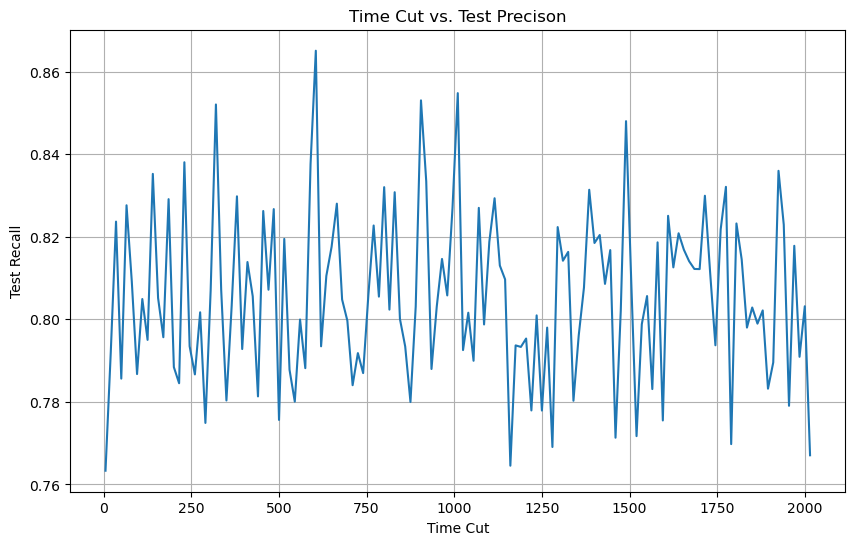

In [13]:
    # Ensure the metrics are numeric
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df['metrics.time_cut'] = pd.to_numeric(df['metrics.time_cut'], errors='coerce')
df['metrics.test_recall'] = pd.to_numeric(df['metrics.test_precision'], errors='coerce')
    
# Plotting time_cut vs. test_accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(x='metrics.time_cut', y='metrics.test_precision', data=df)
plt.title('Time Cut vs. Test Precison')
plt.xlabel('Time Cut')
plt.ylabel('Test Recall')
plt.grid(True)
plt.show()

In [17]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
#mlflow.set_experiment("spyder-experiment")
import mlflow.pytorch
mlflow.set_experiment("GAT Network 2024-09-08 short time cut")

2024/09/08 17:21:52 INFO mlflow.tracking.fluent: Experiment with name 'GAT Network 2024-09-08 short time cut' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/azureuser/rumour-detection-pheme/mlruns/17', creation_time=1725816112710, experiment_id='17', last_update_time=1725816112710, lifecycle_stage='active', name='GAT Network 2024-09-08 short time cut', tags={}>

In [18]:
#
file_path_replies = r"/home/azureuser/rumour-detection-pheme/replies_charlie_hebdo.pkl"
file_path_posts = r"/home/azureuser/rumour-detection-pheme/posts_charlie_hebdo.pkl"

for time_cut in range(1,120,1):
    print(time_cut)
    processor = HeteroDataProcessor(file_path_replies, file_path_posts, time_cut)
    data = processor.process()

    model = GAT(dim_h=64, dim_out=2)
    model = to_hetero(model, data.metadata(), aggr='sum')
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data, model = data.to(device), model.to(device)
   
    with mlflow.start_run():

        for epoch in range(400):
            model.train()
            optimizer.zero_grad()
            out = model(data.x_dict, data.edge_index_dict)['id']
            mask = data['id'].train_mask
            loss = F.cross_entropy(out[mask], data['id'].y[mask])
            loss.backward()
            optimizer.step()
            
            if epoch % 100 == 0:
                print(epoch)
                train_acc = test(data['id'].train_mask)
                val_acc = test(data['id'].val_mask)
                print(f'Epoch: {epoch:>3} | Train Loss: {loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%')

            
        test_acc = test(data['id'].test_mask)
        print(f'Test accuracy: {test_acc*100:.2f}%')

        test_mask = data['id'].test_mask | data['id'].val_mask
        pred = model(data.x_dict, data.edge_index_dict)['id'].argmax(dim=-1)
        true_labels = data['id'].y[test_mask]
        pred_labels = pred[test_mask]
        test_precision =precision_score(true_labels, pred_labels, average='macro')
        test_recall=recall_score(true_labels, pred_labels, average='macro')
        print(f'Test Recall: {test_recall*100:.2f}%')
        print(f'Test Precision: {test_precision*100:.2f}%')

        mlflow.log_metric("train_loss", loss.item(), step=epoch)
        mlflow.log_metric("train_acc", train_acc, step=epoch)
        mlflow.log_metric("val_acc", val_acc, step=epoch)
        mlflow.log_metric("test_acc", test_acc)
        mlflow.log_metric("test_precision",  test_precision)
        mlflow.log_metric("test_recall",  test_recall)

            
        mlflow.log_param("dim_h", 64)
        mlflow.log_param("dim_out", 2)
        mlflow.log_param("learning_rate", 0.001)
        mlflow.log_param("epochs", 400)
        mlflow.log_metric("time_cut", time_cut)



        
            
        mlflow.pytorch.log_model(model, f"GAT_model_{time_cut}")


1


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6940 | Train Acc: 75.59% | Val Acc: 69.67%
100
Epoch: 100 | Train Loss: 0.4622 | Train Acc: 82.87% | Val Acc: 78.00%
200
Epoch: 200 | Train Loss: 0.4081 | Train Acc: 84.37% | Val Acc: 78.00%
300
Epoch: 300 | Train Loss: 0.3950 | Train Acc: 85.37% | Val Acc: 78.33%
Test accuracy: 78.41%
Test Recall: 57.85%
Test Precision: 68.66%


2024/09/08 17:22:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6995 | Train Acc: 70.74% | Val Acc: 70.33%
100
Epoch: 100 | Train Loss: 0.4179 | Train Acc: 83.30% | Val Acc: 80.00%
200
Epoch: 200 | Train Loss: 0.3435 | Train Acc: 87.15% | Val Acc: 82.00%
300
Epoch: 300 | Train Loss: 0.3022 | Train Acc: 89.72% | Val Acc: 82.33%
Test accuracy: 81.73%
Test Recall: 64.25%
Test Precision: 74.47%


2024/09/08 17:22:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


3


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6742 | Train Acc: 77.09% | Val Acc: 80.00%
100
Epoch: 100 | Train Loss: 0.3911 | Train Acc: 84.51% | Val Acc: 83.67%
200
Epoch: 200 | Train Loss: 0.2945 | Train Acc: 89.65% | Val Acc: 85.67%
300
Epoch: 300 | Train Loss: 0.2411 | Train Acc: 91.93% | Val Acc: 85.67%
Test accuracy: 80.73%
Test Recall: 71.42%
Test Precision: 75.14%


2024/09/08 17:22:43 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


4


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6927 | Train Acc: 77.30% | Val Acc: 77.33%
100
Epoch: 100 | Train Loss: 0.3875 | Train Acc: 85.87% | Val Acc: 83.00%
200
Epoch: 200 | Train Loss: 0.2851 | Train Acc: 90.15% | Val Acc: 83.67%
300
Epoch: 300 | Train Loss: 0.2414 | Train Acc: 92.51% | Val Acc: 83.33%
Test accuracy: 83.39%
Test Recall: 70.37%
Test Precision: 78.26%


2024/09/08 17:22:57 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


5


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6778 | Train Acc: 76.16% | Val Acc: 79.00%
100
Epoch: 100 | Train Loss: 0.3712 | Train Acc: 86.08% | Val Acc: 84.00%
200
Epoch: 200 | Train Loss: 0.2719 | Train Acc: 91.29% | Val Acc: 84.33%
300
Epoch: 300 | Train Loss: 0.2058 | Train Acc: 94.22% | Val Acc: 84.67%
Test accuracy: 82.72%
Test Recall: 71.88%
Test Precision: 75.77%


2024/09/08 17:23:12 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


6


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7342 | Train Acc: 30.69% | Val Acc: 39.67%
100
Epoch: 100 | Train Loss: 0.3710 | Train Acc: 85.58% | Val Acc: 79.00%
200
Epoch: 200 | Train Loss: 0.2489 | Train Acc: 91.29% | Val Acc: 81.67%
300
Epoch: 300 | Train Loss: 0.1834 | Train Acc: 95.22% | Val Acc: 82.67%
Test accuracy: 86.71%
Test Recall: 74.67%
Test Precision: 82.47%


2024/09/08 17:23:28 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


7


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7147 | Train Acc: 76.30% | Val Acc: 73.67%
100
Epoch: 100 | Train Loss: 0.3580 | Train Acc: 86.15% | Val Acc: 82.33%
200
Epoch: 200 | Train Loss: 0.2441 | Train Acc: 91.65% | Val Acc: 84.67%
300
Epoch: 300 | Train Loss: 0.1687 | Train Acc: 95.29% | Val Acc: 85.67%
Test accuracy: 85.38%
Test Recall: 75.56%
Test Precision: 80.58%


2024/09/08 17:23:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


8


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7703 | Train Acc: 24.27% | Val Acc: 25.33%
100
Epoch: 100 | Train Loss: 0.3695 | Train Acc: 84.87% | Val Acc: 85.33%
200
Epoch: 200 | Train Loss: 0.2496 | Train Acc: 90.44% | Val Acc: 86.33%
300
Epoch: 300 | Train Loss: 0.1679 | Train Acc: 94.72% | Val Acc: 86.67%
Test accuracy: 85.38%
Test Recall: 78.01%
Test Precision: 80.92%


2024/09/08 17:24:01 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


9


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7420 | Train Acc: 43.61% | Val Acc: 46.33%
100
Epoch: 100 | Train Loss: 0.3763 | Train Acc: 85.15% | Val Acc: 85.00%
200
Epoch: 200 | Train Loss: 0.2426 | Train Acc: 91.15% | Val Acc: 86.67%
300
Epoch: 300 | Train Loss: 0.1668 | Train Acc: 95.50% | Val Acc: 86.00%
Test accuracy: 84.39%
Test Recall: 75.15%
Test Precision: 79.40%


2024/09/08 17:24:19 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


10


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7645 | Train Acc: 29.19% | Val Acc: 25.33%
100
Epoch: 100 | Train Loss: 0.3591 | Train Acc: 85.80% | Val Acc: 83.00%
200
Epoch: 200 | Train Loss: 0.2396 | Train Acc: 90.86% | Val Acc: 86.00%
300
Epoch: 300 | Train Loss: 0.1629 | Train Acc: 95.79% | Val Acc: 86.00%
Test accuracy: 81.40%
Test Recall: 75.74%
Test Precision: 76.42%


2024/09/08 17:24:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


11


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7822 | Train Acc: 24.34% | Val Acc: 23.33%
100
Epoch: 100 | Train Loss: 0.3715 | Train Acc: 84.87% | Val Acc: 80.67%
200
Epoch: 200 | Train Loss: 0.2585 | Train Acc: 89.36% | Val Acc: 82.33%
300
Epoch: 300 | Train Loss: 0.1894 | Train Acc: 94.00% | Val Acc: 82.67%
Test accuracy: 88.37%
Test Recall: 77.09%
Test Precision: 80.72%


2024/09/08 17:24:55 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


12


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6599 | Train Acc: 77.73% | Val Acc: 75.67%
100
Epoch: 100 | Train Loss: 0.3270 | Train Acc: 86.94% | Val Acc: 81.33%
200
Epoch: 200 | Train Loss: 0.2126 | Train Acc: 93.65% | Val Acc: 82.67%
300
Epoch: 300 | Train Loss: 0.1384 | Train Acc: 96.86% | Val Acc: 83.33%
Test accuracy: 87.71%
Test Recall: 77.73%
Test Precision: 80.22%


2024/09/08 17:25:15 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


13


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7233 | Train Acc: 64.24% | Val Acc: 62.67%
100
Epoch: 100 | Train Loss: 0.3440 | Train Acc: 85.80% | Val Acc: 85.67%
200
Epoch: 200 | Train Loss: 0.2203 | Train Acc: 92.01% | Val Acc: 85.67%
300
Epoch: 300 | Train Loss: 0.1497 | Train Acc: 95.72% | Val Acc: 84.33%
Test accuracy: 84.05%
Test Recall: 76.34%
Test Precision: 81.07%


2024/09/08 17:25:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


14


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6990 | Train Acc: 62.24% | Val Acc: 61.00%
100
Epoch: 100 | Train Loss: 0.3281 | Train Acc: 87.51% | Val Acc: 84.67%
200
Epoch: 200 | Train Loss: 0.1749 | Train Acc: 94.36% | Val Acc: 84.67%
300
Epoch: 300 | Train Loss: 0.1176 | Train Acc: 97.14% | Val Acc: 85.33%
Test accuracy: 84.39%
Test Recall: 77.30%
Test Precision: 77.14%


2024/09/08 17:25:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


15


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8797 | Train Acc: 22.41% | Val Acc: 21.33%
100
Epoch: 100 | Train Loss: 0.3657 | Train Acc: 84.87% | Val Acc: 80.00%
200
Epoch: 200 | Train Loss: 0.2542 | Train Acc: 89.86% | Val Acc: 82.00%
300
Epoch: 300 | Train Loss: 0.1697 | Train Acc: 94.86% | Val Acc: 84.67%
Test accuracy: 87.04%
Test Recall: 80.91%
Test Precision: 79.81%


2024/09/08 17:26:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


16


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6799 | Train Acc: 76.30% | Val Acc: 77.33%
100
Epoch: 100 | Train Loss: 0.3388 | Train Acc: 86.30% | Val Acc: 83.33%
200
Epoch: 200 | Train Loss: 0.2195 | Train Acc: 92.01% | Val Acc: 86.00%
300
Epoch: 300 | Train Loss: 0.1440 | Train Acc: 95.57% | Val Acc: 84.67%
Test accuracy: 88.37%
Test Recall: 76.79%
Test Precision: 81.44%


2024/09/08 17:26:33 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


17


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7474 | Train Acc: 40.83% | Val Acc: 36.67%
100
Epoch: 100 | Train Loss: 0.3526 | Train Acc: 85.22% | Val Acc: 86.67%
200
Epoch: 200 | Train Loss: 0.2230 | Train Acc: 91.58% | Val Acc: 88.00%
300
Epoch: 300 | Train Loss: 0.1458 | Train Acc: 95.57% | Val Acc: 87.67%
Test accuracy: 83.72%
Test Recall: 76.26%
Test Precision: 77.83%


2024/09/08 17:26:53 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


18


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7483 | Train Acc: 26.34% | Val Acc: 30.00%
100
Epoch: 100 | Train Loss: 0.3453 | Train Acc: 86.08% | Val Acc: 82.33%
200
Epoch: 200 | Train Loss: 0.2223 | Train Acc: 91.79% | Val Acc: 83.33%
300
Epoch: 300 | Train Loss: 0.1220 | Train Acc: 96.72% | Val Acc: 83.67%
Test accuracy: 85.05%
Test Recall: 71.93%
Test Precision: 79.70%


2024/09/08 17:27:14 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


19


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8014 | Train Acc: 30.62% | Val Acc: 25.33%
100
Epoch: 100 | Train Loss: 0.3465 | Train Acc: 85.94% | Val Acc: 80.00%
200
Epoch: 200 | Train Loss: 0.2223 | Train Acc: 91.22% | Val Acc: 81.67%
300
Epoch: 300 | Train Loss: 0.1620 | Train Acc: 95.29% | Val Acc: 83.67%
Test accuracy: 88.37%
Test Recall: 82.60%
Test Precision: 78.11%


2024/09/08 17:27:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


20


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7420 | Train Acc: 40.76% | Val Acc: 42.67%
100
Epoch: 100 | Train Loss: 0.3462 | Train Acc: 85.37% | Val Acc: 87.33%
200
Epoch: 200 | Train Loss: 0.2107 | Train Acc: 92.79% | Val Acc: 87.67%
300
Epoch: 300 | Train Loss: 0.1285 | Train Acc: 97.50% | Val Acc: 88.00%
Test accuracy: 86.38%
Test Recall: 80.51%
Test Precision: 83.54%


2024/09/08 17:27:56 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


21


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6763 | Train Acc: 69.59% | Val Acc: 70.67%
100
Epoch: 100 | Train Loss: 0.3321 | Train Acc: 86.80% | Val Acc: 84.67%
200
Epoch: 200 | Train Loss: 0.1919 | Train Acc: 94.43% | Val Acc: 86.67%
300
Epoch: 300 | Train Loss: 0.1152 | Train Acc: 97.50% | Val Acc: 88.33%
Test accuracy: 86.38%
Test Recall: 79.06%
Test Precision: 81.25%


2024/09/08 17:28:16 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


22


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7452 | Train Acc: 53.68% | Val Acc: 48.33%
100
Epoch: 100 | Train Loss: 0.3307 | Train Acc: 86.72% | Val Acc: 81.67%
200
Epoch: 200 | Train Loss: 0.2087 | Train Acc: 93.15% | Val Acc: 86.33%
300
Epoch: 300 | Train Loss: 0.1035 | Train Acc: 97.14% | Val Acc: 86.67%
Test accuracy: 87.38%
Test Recall: 80.71%
Test Precision: 82.76%


2024/09/08 17:28:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


23


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6545 | Train Acc: 77.52% | Val Acc: 75.33%
100
Epoch: 100 | Train Loss: 0.3021 | Train Acc: 88.15% | Val Acc: 84.33%
200
Epoch: 200 | Train Loss: 0.1795 | Train Acc: 94.22% | Val Acc: 86.00%
300
Epoch: 300 | Train Loss: 0.1113 | Train Acc: 97.07% | Val Acc: 86.00%
Test accuracy: 86.38%
Test Recall: 81.16%
Test Precision: 80.32%


2024/09/08 17:29:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


24


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7517 | Train Acc: 53.89% | Val Acc: 55.67%
100
Epoch: 100 | Train Loss: 0.3278 | Train Acc: 86.65% | Val Acc: 84.00%
200
Epoch: 200 | Train Loss: 0.1958 | Train Acc: 93.29% | Val Acc: 88.00%
300
Epoch: 300 | Train Loss: 0.1160 | Train Acc: 97.14% | Val Acc: 88.67%
Test accuracy: 83.72%
Test Recall: 80.07%
Test Precision: 79.19%


2024/09/08 17:29:22 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


25


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7669 | Train Acc: 36.90% | Val Acc: 34.33%
100
Epoch: 100 | Train Loss: 0.3273 | Train Acc: 86.58% | Val Acc: 84.00%
200
Epoch: 200 | Train Loss: 0.1988 | Train Acc: 94.08% | Val Acc: 83.33%
300
Epoch: 300 | Train Loss: 0.1101 | Train Acc: 97.50% | Val Acc: 82.67%
Test accuracy: 87.04%
Test Recall: 77.73%
Test Precision: 77.10%


2024/09/08 17:29:43 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


26


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6959 | Train Acc: 67.38% | Val Acc: 69.00%
100
Epoch: 100 | Train Loss: 0.3298 | Train Acc: 86.22% | Val Acc: 86.00%
200
Epoch: 200 | Train Loss: 0.2012 | Train Acc: 93.43% | Val Acc: 87.33%
300
Epoch: 300 | Train Loss: 0.1049 | Train Acc: 97.00% | Val Acc: 88.00%
Test accuracy: 87.71%
Test Recall: 77.86%
Test Precision: 82.20%


2024/09/08 17:30:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


27


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7146 | Train Acc: 70.81% | Val Acc: 66.00%
100
Epoch: 100 | Train Loss: 0.3242 | Train Acc: 85.94% | Val Acc: 83.33%
200
Epoch: 200 | Train Loss: 0.1896 | Train Acc: 93.58% | Val Acc: 83.33%
300
Epoch: 300 | Train Loss: 0.1045 | Train Acc: 97.64% | Val Acc: 82.00%
Test accuracy: 87.71%
Test Recall: 74.16%
Test Precision: 80.73%


2024/09/08 17:30:28 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


28


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7599 | Train Acc: 26.55% | Val Acc: 26.67%
100
Epoch: 100 | Train Loss: 0.3441 | Train Acc: 86.22% | Val Acc: 82.33%
200
Epoch: 200 | Train Loss: 0.2091 | Train Acc: 92.29% | Val Acc: 81.67%
300
Epoch: 300 | Train Loss: 0.1102 | Train Acc: 97.14% | Val Acc: 84.00%
Test accuracy: 87.04%
Test Recall: 76.79%
Test Precision: 77.61%


2024/09/08 17:30:50 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


29


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7225 | Train Acc: 56.53% | Val Acc: 56.67%
100
Epoch: 100 | Train Loss: 0.3108 | Train Acc: 86.87% | Val Acc: 82.33%
200
Epoch: 200 | Train Loss: 0.1807 | Train Acc: 93.29% | Val Acc: 85.00%
300
Epoch: 300 | Train Loss: 0.1272 | Train Acc: 96.15% | Val Acc: 86.33%
Test accuracy: 85.38%
Test Recall: 78.28%
Test Precision: 76.78%


2024/09/08 17:31:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


30


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7123 | Train Acc: 56.10% | Val Acc: 55.33%
100
Epoch: 100 | Train Loss: 0.3123 | Train Acc: 87.29% | Val Acc: 84.67%
200
Epoch: 200 | Train Loss: 0.1898 | Train Acc: 93.72% | Val Acc: 85.67%
300
Epoch: 300 | Train Loss: 0.0957 | Train Acc: 98.00% | Val Acc: 87.00%
Test accuracy: 87.71%
Test Recall: 78.33%
Test Precision: 84.34%


2024/09/08 17:31:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


31


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7075 | Train Acc: 57.46% | Val Acc: 63.33%
100
Epoch: 100 | Train Loss: 0.3186 | Train Acc: 87.37% | Val Acc: 83.67%
200
Epoch: 200 | Train Loss: 0.1921 | Train Acc: 93.72% | Val Acc: 85.33%
300
Epoch: 300 | Train Loss: 0.1090 | Train Acc: 97.64% | Val Acc: 84.00%
Test accuracy: 87.38%
Test Recall: 74.93%
Test Precision: 80.50%


2024/09/08 17:32:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


32


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7789 | Train Acc: 29.26% | Val Acc: 31.67%
100
Epoch: 100 | Train Loss: 0.3323 | Train Acc: 86.37% | Val Acc: 85.33%
200
Epoch: 200 | Train Loss: 0.1901 | Train Acc: 93.79% | Val Acc: 86.67%
300
Epoch: 300 | Train Loss: 0.1132 | Train Acc: 97.00% | Val Acc: 86.33%
Test accuracy: 85.71%
Test Recall: 80.88%
Test Precision: 80.58%


2024/09/08 17:32:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


33


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8278 | Train Acc: 69.16% | Val Acc: 69.00%
100
Epoch: 100 | Train Loss: 0.3292 | Train Acc: 85.51% | Val Acc: 86.67%
200
Epoch: 200 | Train Loss: 0.1986 | Train Acc: 92.58% | Val Acc: 86.33%
300
Epoch: 300 | Train Loss: 0.1124 | Train Acc: 96.50% | Val Acc: 87.00%
Test accuracy: 86.71%
Test Recall: 82.02%
Test Precision: 81.68%


2024/09/08 17:32:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


34


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9496 | Train Acc: 22.34% | Val Acc: 20.67%
100
Epoch: 100 | Train Loss: 0.3393 | Train Acc: 85.01% | Val Acc: 79.67%
200
Epoch: 200 | Train Loss: 0.2307 | Train Acc: 91.51% | Val Acc: 83.67%
300
Epoch: 300 | Train Loss: 0.1383 | Train Acc: 96.00% | Val Acc: 85.33%
Test accuracy: 82.39%
Test Recall: 74.61%
Test Precision: 78.32%


2024/09/08 17:33:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


35


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7459 | Train Acc: 34.90% | Val Acc: 36.00%
100
Epoch: 100 | Train Loss: 0.3313 | Train Acc: 86.44% | Val Acc: 82.00%
200
Epoch: 200 | Train Loss: 0.2015 | Train Acc: 92.93% | Val Acc: 83.00%
300
Epoch: 300 | Train Loss: 0.1194 | Train Acc: 97.00% | Val Acc: 83.00%
Test accuracy: 86.05%
Test Recall: 78.66%
Test Precision: 78.36%


2024/09/08 17:33:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


36


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7908 | Train Acc: 64.88% | Val Acc: 68.33%
100
Epoch: 100 | Train Loss: 0.3263 | Train Acc: 84.80% | Val Acc: 84.33%
200
Epoch: 200 | Train Loss: 0.2248 | Train Acc: 91.58% | Val Acc: 86.67%
300
Epoch: 300 | Train Loss: 0.1418 | Train Acc: 95.22% | Val Acc: 88.00%
Test accuracy: 86.71%
Test Recall: 82.62%
Test Precision: 84.02%


2024/09/08 17:33:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


37


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7820 | Train Acc: 23.84% | Val Acc: 20.67%
100
Epoch: 100 | Train Loss: 0.3503 | Train Acc: 85.30% | Val Acc: 84.67%
200
Epoch: 200 | Train Loss: 0.2241 | Train Acc: 91.15% | Val Acc: 87.33%
300
Epoch: 300 | Train Loss: 0.1364 | Train Acc: 95.57% | Val Acc: 87.00%
Test accuracy: 86.38%
Test Recall: 76.43%
Test Precision: 80.07%


2024/09/08 17:34:16 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


38


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8265 | Train Acc: 25.84% | Val Acc: 19.00%
100
Epoch: 100 | Train Loss: 0.3603 | Train Acc: 84.87% | Val Acc: 88.00%
200
Epoch: 200 | Train Loss: 0.2398 | Train Acc: 91.22% | Val Acc: 88.67%
300
Epoch: 300 | Train Loss: 0.1526 | Train Acc: 95.93% | Val Acc: 89.00%
Test accuracy: 86.71%
Test Recall: 77.13%
Test Precision: 83.05%


2024/09/08 17:34:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


39


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7600 | Train Acc: 44.04% | Val Acc: 46.00%
100
Epoch: 100 | Train Loss: 0.3211 | Train Acc: 86.37% | Val Acc: 85.00%
200
Epoch: 200 | Train Loss: 0.2003 | Train Acc: 92.72% | Val Acc: 84.67%
300
Epoch: 300 | Train Loss: 0.1339 | Train Acc: 96.29% | Val Acc: 84.33%
Test accuracy: 85.05%
Test Recall: 79.16%
Test Precision: 77.31%


2024/09/08 17:35:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


40


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7288 | Train Acc: 75.09% | Val Acc: 75.33%
100
Epoch: 100 | Train Loss: 0.3264 | Train Acc: 86.08% | Val Acc: 87.33%
200
Epoch: 200 | Train Loss: 0.2089 | Train Acc: 91.51% | Val Acc: 88.00%
300
Epoch: 300 | Train Loss: 0.1126 | Train Acc: 95.57% | Val Acc: 87.00%
Test accuracy: 81.40%
Test Recall: 79.06%
Test Precision: 80.06%


2024/09/08 17:35:24 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


41


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7409 | Train Acc: 51.25% | Val Acc: 50.67%
100
Epoch: 100 | Train Loss: 0.3135 | Train Acc: 87.72% | Val Acc: 84.67%
200
Epoch: 200 | Train Loss: 0.1942 | Train Acc: 93.36% | Val Acc: 87.00%
300
Epoch: 300 | Train Loss: 0.1028 | Train Acc: 98.29% | Val Acc: 88.67%
Test accuracy: 86.05%
Test Recall: 80.79%
Test Precision: 82.82%


2024/09/08 17:35:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


42


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8629 | Train Acc: 55.96% | Val Acc: 55.67%
100
Epoch: 100 | Train Loss: 0.3345 | Train Acc: 85.30% | Val Acc: 82.67%
200
Epoch: 200 | Train Loss: 0.2391 | Train Acc: 90.86% | Val Acc: 85.67%
300
Epoch: 300 | Train Loss: 0.1535 | Train Acc: 95.07% | Val Acc: 87.00%
Test accuracy: 85.38%
Test Recall: 80.47%
Test Precision: 80.95%


2024/09/08 17:36:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


43


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6008 | Train Acc: 77.37% | Val Acc: 79.33%
100
Epoch: 100 | Train Loss: 0.3048 | Train Acc: 86.94% | Val Acc: 89.67%
200
Epoch: 200 | Train Loss: 0.1779 | Train Acc: 93.65% | Val Acc: 90.00%
300
Epoch: 300 | Train Loss: 0.1089 | Train Acc: 98.14% | Val Acc: 89.33%
Test accuracy: 86.38%
Test Recall: 81.28%
Test Precision: 82.01%


2024/09/08 17:36:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


44


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8623 | Train Acc: 36.97% | Val Acc: 37.33%
100
Epoch: 100 | Train Loss: 0.3360 | Train Acc: 85.22% | Val Acc: 79.67%
200
Epoch: 200 | Train Loss: 0.2066 | Train Acc: 92.29% | Val Acc: 84.00%
300
Epoch: 300 | Train Loss: 0.1096 | Train Acc: 97.29% | Val Acc: 84.00%
Test accuracy: 84.05%
Test Recall: 75.35%
Test Precision: 78.42%


2024/09/08 17:36:57 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


45


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6845 | Train Acc: 76.09% | Val Acc: 69.67%
100
Epoch: 100 | Train Loss: 0.3086 | Train Acc: 87.37% | Val Acc: 83.67%
200
Epoch: 200 | Train Loss: 0.1983 | Train Acc: 93.00% | Val Acc: 83.67%
300
Epoch: 300 | Train Loss: 0.1304 | Train Acc: 97.29% | Val Acc: 86.00%
Test accuracy: 88.37%
Test Recall: 80.18%
Test Precision: 83.30%


2024/09/08 17:37:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


46


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6731 | Train Acc: 76.87% | Val Acc: 77.67%
100
Epoch: 100 | Train Loss: 0.3157 | Train Acc: 87.08% | Val Acc: 86.33%
200
Epoch: 200 | Train Loss: 0.1940 | Train Acc: 92.93% | Val Acc: 88.67%
300
Epoch: 300 | Train Loss: 0.1164 | Train Acc: 96.72% | Val Acc: 87.67%
Test accuracy: 89.37%
Test Recall: 80.36%
Test Precision: 85.09%


2024/09/08 17:37:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


47


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7083 | Train Acc: 68.95% | Val Acc: 69.00%
100
Epoch: 100 | Train Loss: 0.3099 | Train Acc: 87.15% | Val Acc: 83.00%
200
Epoch: 200 | Train Loss: 0.1712 | Train Acc: 94.79% | Val Acc: 85.00%
300
Epoch: 300 | Train Loss: 0.0795 | Train Acc: 97.50% | Val Acc: 85.00%
Test accuracy: 85.71%
Test Recall: 81.44%
Test Precision: 77.44%


2024/09/08 17:38:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


48


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7590 | Train Acc: 29.41% | Val Acc: 30.33%
100
Epoch: 100 | Train Loss: 0.3088 | Train Acc: 87.01% | Val Acc: 84.33%
200
Epoch: 200 | Train Loss: 0.1949 | Train Acc: 92.65% | Val Acc: 87.33%
300
Epoch: 300 | Train Loss: 0.1046 | Train Acc: 97.57% | Val Acc: 87.33%
Test accuracy: 85.05%
Test Recall: 76.21%
Test Precision: 82.14%


2024/09/08 17:38:31 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


49


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7157 | Train Acc: 62.24% | Val Acc: 61.67%
100
Epoch: 100 | Train Loss: 0.3112 | Train Acc: 86.80% | Val Acc: 81.33%
200
Epoch: 200 | Train Loss: 0.2023 | Train Acc: 92.72% | Val Acc: 84.67%
300
Epoch: 300 | Train Loss: 0.1035 | Train Acc: 97.22% | Val Acc: 85.67%
Test accuracy: 85.38%
Test Recall: 80.05%
Test Precision: 79.77%


2024/09/08 17:38:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


50


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6850 | Train Acc: 76.95% | Val Acc: 79.67%
100
Epoch: 100 | Train Loss: 0.3051 | Train Acc: 87.01% | Val Acc: 88.33%
200
Epoch: 200 | Train Loss: 0.1921 | Train Acc: 92.51% | Val Acc: 86.00%
300
Epoch: 300 | Train Loss: 0.1039 | Train Acc: 97.79% | Val Acc: 87.00%
Test accuracy: 89.37%
Test Recall: 78.82%
Test Precision: 82.01%


2024/09/08 17:39:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


51


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8396 | Train Acc: 23.05% | Val Acc: 29.67%
100
Epoch: 100 | Train Loss: 0.3281 | Train Acc: 84.87% | Val Acc: 83.00%
200
Epoch: 200 | Train Loss: 0.2290 | Train Acc: 91.29% | Val Acc: 87.33%
300
Epoch: 300 | Train Loss: 0.1200 | Train Acc: 96.93% | Val Acc: 89.00%
Test accuracy: 84.05%
Test Recall: 77.02%
Test Precision: 83.08%


2024/09/08 17:39:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


52


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7596 | Train Acc: 73.38% | Val Acc: 71.67%
100
Epoch: 100 | Train Loss: 0.3111 | Train Acc: 86.80% | Val Acc: 85.00%
200
Epoch: 200 | Train Loss: 0.2071 | Train Acc: 92.22% | Val Acc: 87.00%
300
Epoch: 300 | Train Loss: 0.1200 | Train Acc: 96.43% | Val Acc: 86.33%
Test accuracy: 86.38%
Test Recall: 78.56%
Test Precision: 81.16%


2024/09/08 17:40:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


53


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6380 | Train Acc: 77.30% | Val Acc: 79.67%
100
Epoch: 100 | Train Loss: 0.3076 | Train Acc: 88.01% | Val Acc: 78.00%
200
Epoch: 200 | Train Loss: 0.1920 | Train Acc: 93.50% | Val Acc: 81.33%
300
Epoch: 300 | Train Loss: 0.1034 | Train Acc: 97.64% | Val Acc: 83.67%
Test accuracy: 87.04%
Test Recall: 80.29%
Test Precision: 78.87%


2024/09/08 17:40:31 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


54


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7165 | Train Acc: 60.10% | Val Acc: 56.00%
100
Epoch: 100 | Train Loss: 0.3117 | Train Acc: 86.87% | Val Acc: 85.67%
200
Epoch: 200 | Train Loss: 0.2060 | Train Acc: 93.00% | Val Acc: 88.00%
300
Epoch: 300 | Train Loss: 0.1105 | Train Acc: 97.22% | Val Acc: 88.67%
Test accuracy: 84.05%
Test Recall: 78.70%
Test Precision: 79.34%


2024/09/08 17:40:55 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


55


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7444 | Train Acc: 44.54% | Val Acc: 44.00%
100
Epoch: 100 | Train Loss: 0.3063 | Train Acc: 87.79% | Val Acc: 81.00%
200
Epoch: 200 | Train Loss: 0.1914 | Train Acc: 92.29% | Val Acc: 83.33%
300
Epoch: 300 | Train Loss: 0.1340 | Train Acc: 96.07% | Val Acc: 84.33%
Test accuracy: 88.04%
Test Recall: 81.05%
Test Precision: 79.39%


2024/09/08 17:41:19 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


56


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7611 | Train Acc: 65.95% | Val Acc: 69.00%
100
Epoch: 100 | Train Loss: 0.3206 | Train Acc: 86.72% | Val Acc: 83.33%
200
Epoch: 200 | Train Loss: 0.1972 | Train Acc: 92.79% | Val Acc: 85.33%
300
Epoch: 300 | Train Loss: 0.1207 | Train Acc: 96.36% | Val Acc: 86.33%
Test accuracy: 87.04%
Test Recall: 81.88%
Test Precision: 81.08%


2024/09/08 17:41:43 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


57


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7328 | Train Acc: 49.96% | Val Acc: 46.33%
100
Epoch: 100 | Train Loss: 0.3124 | Train Acc: 86.51% | Val Acc: 84.33%
200
Epoch: 200 | Train Loss: 0.1935 | Train Acc: 92.51% | Val Acc: 86.33%
300
Epoch: 300 | Train Loss: 0.1240 | Train Acc: 96.07% | Val Acc: 88.00%
Test accuracy: 85.71%
Test Recall: 81.38%
Test Precision: 79.92%


2024/09/08 17:42:07 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


58


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7507 | Train Acc: 68.67% | Val Acc: 66.00%
100
Epoch: 100 | Train Loss: 0.3173 | Train Acc: 86.51% | Val Acc: 83.67%
200
Epoch: 200 | Train Loss: 0.1850 | Train Acc: 92.36% | Val Acc: 84.00%
300
Epoch: 300 | Train Loss: 0.1065 | Train Acc: 95.65% | Val Acc: 86.00%
Test accuracy: 86.38%
Test Recall: 83.07%
Test Precision: 80.31%


2024/09/08 17:42:31 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


59


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7142 | Train Acc: 60.67% | Val Acc: 58.33%
100
Epoch: 100 | Train Loss: 0.3307 | Train Acc: 87.01% | Val Acc: 86.33%
200
Epoch: 200 | Train Loss: 0.2117 | Train Acc: 91.29% | Val Acc: 85.00%
300
Epoch: 300 | Train Loss: 0.1353 | Train Acc: 95.93% | Val Acc: 84.67%
Test accuracy: 87.71%
Test Recall: 80.40%
Test Precision: 79.12%


2024/09/08 17:42:55 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


60


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7931 | Train Acc: 27.69% | Val Acc: 30.00%
100
Epoch: 100 | Train Loss: 0.3436 | Train Acc: 84.94% | Val Acc: 84.67%
200
Epoch: 200 | Train Loss: 0.2415 | Train Acc: 90.65% | Val Acc: 85.67%
300
Epoch: 300 | Train Loss: 0.1500 | Train Acc: 95.07% | Val Acc: 86.00%
Test accuracy: 84.72%
Test Recall: 79.69%
Test Precision: 80.46%


2024/09/08 17:43:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


61


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6028 | Train Acc: 77.59% | Val Acc: 76.00%
100
Epoch: 100 | Train Loss: 0.3111 | Train Acc: 86.30% | Val Acc: 82.33%
200
Epoch: 200 | Train Loss: 0.1596 | Train Acc: 94.93% | Val Acc: 85.00%
300
Epoch: 300 | Train Loss: 0.0772 | Train Acc: 98.72% | Val Acc: 85.00%
Test accuracy: 86.71%
Test Recall: 77.57%
Test Precision: 78.68%


2024/09/08 17:43:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


62


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7994 | Train Acc: 36.19% | Val Acc: 38.33%
100
Epoch: 100 | Train Loss: 0.3180 | Train Acc: 87.51% | Val Acc: 83.33%
200
Epoch: 200 | Train Loss: 0.2198 | Train Acc: 92.22% | Val Acc: 84.00%
300
Epoch: 300 | Train Loss: 0.1414 | Train Acc: 95.93% | Val Acc: 84.00%
Test accuracy: 85.71%
Test Recall: 79.88%
Test Precision: 79.12%


2024/09/08 17:44:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


63


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6920 | Train Acc: 77.16% | Val Acc: 72.67%
100
Epoch: 100 | Train Loss: 0.3129 | Train Acc: 86.72% | Val Acc: 82.67%
200
Epoch: 200 | Train Loss: 0.1808 | Train Acc: 93.29% | Val Acc: 85.67%
300
Epoch: 300 | Train Loss: 0.1050 | Train Acc: 97.07% | Val Acc: 84.33%
Test accuracy: 88.70%
Test Recall: 81.07%
Test Precision: 82.29%


2024/09/08 17:44:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


64


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6790 | Train Acc: 77.44% | Val Acc: 79.33%
100
Epoch: 100 | Train Loss: 0.3117 | Train Acc: 87.37% | Val Acc: 86.33%
200
Epoch: 200 | Train Loss: 0.2180 | Train Acc: 91.65% | Val Acc: 88.33%
300
Epoch: 300 | Train Loss: 0.1355 | Train Acc: 95.15% | Val Acc: 90.33%
Test accuracy: 85.71%
Test Recall: 85.02%
Test Precision: 82.79%


2024/09/08 17:44:59 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


65


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7440 | Train Acc: 66.95% | Val Acc: 63.67%
100
Epoch: 100 | Train Loss: 0.3118 | Train Acc: 86.87% | Val Acc: 81.33%
200
Epoch: 200 | Train Loss: 0.1997 | Train Acc: 92.58% | Val Acc: 84.33%
300
Epoch: 300 | Train Loss: 0.1020 | Train Acc: 97.07% | Val Acc: 86.33%
Test accuracy: 92.03%
Test Recall: 82.68%
Test Precision: 83.80%


2024/09/08 17:45:24 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


66


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6633 | Train Acc: 77.52% | Val Acc: 76.67%
100
Epoch: 100 | Train Loss: 0.2961 | Train Acc: 87.29% | Val Acc: 77.67%
200
Epoch: 200 | Train Loss: 0.1870 | Train Acc: 93.72% | Val Acc: 81.67%
300
Epoch: 300 | Train Loss: 0.1135 | Train Acc: 97.22% | Val Acc: 82.33%
Test accuracy: 84.72%
Test Recall: 76.97%
Test Precision: 76.68%


2024/09/08 17:45:49 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


67


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9494 | Train Acc: 44.54% | Val Acc: 42.00%
100
Epoch: 100 | Train Loss: 0.3383 | Train Acc: 84.08% | Val Acc: 87.33%
200
Epoch: 200 | Train Loss: 0.2372 | Train Acc: 90.15% | Val Acc: 87.00%
300
Epoch: 300 | Train Loss: 0.1491 | Train Acc: 95.43% | Val Acc: 88.33%
Test accuracy: 82.72%
Test Recall: 77.77%
Test Precision: 81.33%


2024/09/08 17:46:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


68


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7559 | Train Acc: 54.03% | Val Acc: 50.33%
100
Epoch: 100 | Train Loss: 0.3254 | Train Acc: 86.30% | Val Acc: 84.67%
200
Epoch: 200 | Train Loss: 0.1976 | Train Acc: 92.36% | Val Acc: 84.33%
300
Epoch: 300 | Train Loss: 0.1226 | Train Acc: 96.29% | Val Acc: 84.00%
Test accuracy: 85.05%
Test Recall: 78.23%
Test Precision: 76.82%


2024/09/08 17:46:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


69


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6256 | Train Acc: 77.66% | Val Acc: 76.67%
100
Epoch: 100 | Train Loss: 0.2990 | Train Acc: 87.37% | Val Acc: 82.67%
200
Epoch: 200 | Train Loss: 0.1682 | Train Acc: 94.22% | Val Acc: 83.67%
300
Epoch: 300 | Train Loss: 0.0951 | Train Acc: 97.07% | Val Acc: 83.00%
Test accuracy: 88.04%
Test Recall: 77.44%
Test Precision: 80.52%


2024/09/08 17:47:03 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


70


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6704 | Train Acc: 74.52% | Val Acc: 75.33%
100
Epoch: 100 | Train Loss: 0.2896 | Train Acc: 87.94% | Val Acc: 85.33%
200
Epoch: 200 | Train Loss: 0.1716 | Train Acc: 94.08% | Val Acc: 86.67%
300
Epoch: 300 | Train Loss: 0.0821 | Train Acc: 98.22% | Val Acc: 86.67%
Test accuracy: 83.06%
Test Recall: 77.43%
Test Precision: 78.85%


2024/09/08 17:47:28 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


71


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7845 | Train Acc: 28.69% | Val Acc: 28.67%
100
Epoch: 100 | Train Loss: 0.3289 | Train Acc: 85.44% | Val Acc: 86.00%
200
Epoch: 200 | Train Loss: 0.2184 | Train Acc: 90.86% | Val Acc: 89.00%
300
Epoch: 300 | Train Loss: 0.1218 | Train Acc: 97.00% | Val Acc: 88.67%
Test accuracy: 81.40%
Test Recall: 73.09%
Test Precision: 79.20%


2024/09/08 17:47:53 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


72


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7475 | Train Acc: 48.61% | Val Acc: 50.00%
100
Epoch: 100 | Train Loss: 0.3233 | Train Acc: 86.58% | Val Acc: 86.67%
200
Epoch: 200 | Train Loss: 0.2298 | Train Acc: 91.36% | Val Acc: 88.67%
300
Epoch: 300 | Train Loss: 0.1419 | Train Acc: 95.22% | Val Acc: 88.67%
Test accuracy: 83.72%
Test Recall: 77.49%
Test Precision: 82.16%


2024/09/08 17:48:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


73


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6389 | Train Acc: 74.02% | Val Acc: 73.00%
100
Epoch: 100 | Train Loss: 0.2853 | Train Acc: 88.58% | Val Acc: 84.67%
200
Epoch: 200 | Train Loss: 0.1789 | Train Acc: 93.65% | Val Acc: 85.00%
300
Epoch: 300 | Train Loss: 0.1124 | Train Acc: 96.22% | Val Acc: 86.67%
Test accuracy: 87.38%
Test Recall: 82.38%
Test Precision: 80.64%


2024/09/08 17:48:43 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


74


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 1.0592 | Train Acc: 22.20% | Val Acc: 24.00%
100
Epoch: 100 | Train Loss: 0.3465 | Train Acc: 84.87% | Val Acc: 80.67%
200
Epoch: 200 | Train Loss: 0.2518 | Train Acc: 90.22% | Val Acc: 84.00%
300
Epoch: 300 | Train Loss: 0.1540 | Train Acc: 95.29% | Val Acc: 86.33%
Test accuracy: 89.04%
Test Recall: 78.35%
Test Precision: 82.73%


2024/09/08 17:49:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


75


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7704 | Train Acc: 29.12% | Val Acc: 25.67%
100
Epoch: 100 | Train Loss: 0.3309 | Train Acc: 85.72% | Val Acc: 85.67%
200
Epoch: 200 | Train Loss: 0.2167 | Train Acc: 91.22% | Val Acc: 85.00%
300
Epoch: 300 | Train Loss: 0.1202 | Train Acc: 95.22% | Val Acc: 87.33%
Test accuracy: 85.05%
Test Recall: 83.57%
Test Precision: 79.78%


2024/09/08 17:49:33 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


76


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6203 | Train Acc: 77.52% | Val Acc: 75.67%
100
Epoch: 100 | Train Loss: 0.2926 | Train Acc: 89.08% | Val Acc: 82.33%
200
Epoch: 200 | Train Loss: 0.1488 | Train Acc: 95.15% | Val Acc: 84.67%
300
Epoch: 300 | Train Loss: 0.0785 | Train Acc: 98.43% | Val Acc: 82.67%
Test accuracy: 86.05%
Test Recall: 77.88%
Test Precision: 78.19%


2024/09/08 17:49:59 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


77


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7024 | Train Acc: 75.73% | Val Acc: 75.67%
100
Epoch: 100 | Train Loss: 0.3048 | Train Acc: 86.72% | Val Acc: 79.00%
200
Epoch: 200 | Train Loss: 0.1650 | Train Acc: 93.58% | Val Acc: 83.33%
300
Epoch: 300 | Train Loss: 0.0838 | Train Acc: 97.57% | Val Acc: 83.67%
Test accuracy: 86.71%
Test Recall: 76.22%
Test Precision: 79.93%


2024/09/08 17:50:24 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


78


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6882 | Train Acc: 59.46% | Val Acc: 61.00%
100
Epoch: 100 | Train Loss: 0.3019 | Train Acc: 87.58% | Val Acc: 82.67%
200
Epoch: 200 | Train Loss: 0.1827 | Train Acc: 93.15% | Val Acc: 83.33%
300
Epoch: 300 | Train Loss: 0.0967 | Train Acc: 97.29% | Val Acc: 84.00%
Test accuracy: 86.38%
Test Recall: 78.16%
Test Precision: 75.73%


2024/09/08 17:50:49 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


79


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8715 | Train Acc: 28.91% | Val Acc: 25.33%
100
Epoch: 100 | Train Loss: 0.3462 | Train Acc: 84.51% | Val Acc: 86.67%
200
Epoch: 200 | Train Loss: 0.2268 | Train Acc: 91.29% | Val Acc: 87.00%
300
Epoch: 300 | Train Loss: 0.1403 | Train Acc: 96.93% | Val Acc: 87.33%
Test accuracy: 86.05%
Test Recall: 80.09%
Test Precision: 79.74%


2024/09/08 17:51:15 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


80


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9108 | Train Acc: 21.48% | Val Acc: 25.00%
100
Epoch: 100 | Train Loss: 0.3265 | Train Acc: 84.80% | Val Acc: 81.33%
200
Epoch: 200 | Train Loss: 0.2150 | Train Acc: 90.44% | Val Acc: 84.33%
300
Epoch: 300 | Train Loss: 0.1311 | Train Acc: 94.50% | Val Acc: 84.33%
Test accuracy: 85.38%
Test Recall: 80.64%
Test Precision: 80.64%


2024/09/08 17:51:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


81


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6495 | Train Acc: 77.23% | Val Acc: 80.33%
100
Epoch: 100 | Train Loss: 0.3107 | Train Acc: 87.08% | Val Acc: 86.00%
200
Epoch: 200 | Train Loss: 0.1873 | Train Acc: 93.00% | Val Acc: 86.00%
300
Epoch: 300 | Train Loss: 0.1035 | Train Acc: 96.79% | Val Acc: 85.33%
Test accuracy: 87.71%
Test Recall: 83.46%
Test Precision: 79.55%


2024/09/08 17:52:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


82


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6577 | Train Acc: 76.52% | Val Acc: 77.00%
100
Epoch: 100 | Train Loss: 0.2892 | Train Acc: 87.72% | Val Acc: 86.00%
200
Epoch: 200 | Train Loss: 0.1793 | Train Acc: 92.86% | Val Acc: 89.00%
300
Epoch: 300 | Train Loss: 0.0986 | Train Acc: 97.36% | Val Acc: 88.67%
Test accuracy: 85.38%
Test Recall: 77.61%
Test Precision: 82.33%


2024/09/08 17:52:29 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


83


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9738 | Train Acc: 23.63% | Val Acc: 24.67%
100
Epoch: 100 | Train Loss: 0.3493 | Train Acc: 85.01% | Val Acc: 84.00%
200
Epoch: 200 | Train Loss: 0.2383 | Train Acc: 90.22% | Val Acc: 84.33%
300
Epoch: 300 | Train Loss: 0.1338 | Train Acc: 96.07% | Val Acc: 84.33%
Test accuracy: 87.04%
Test Recall: 76.97%
Test Precision: 80.31%


2024/09/08 17:52:55 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


84


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9316 | Train Acc: 29.26% | Val Acc: 22.33%
100
Epoch: 100 | Train Loss: 0.3283 | Train Acc: 87.01% | Val Acc: 81.33%
200
Epoch: 200 | Train Loss: 0.2320 | Train Acc: 91.15% | Val Acc: 83.33%
300
Epoch: 300 | Train Loss: 0.1475 | Train Acc: 96.15% | Val Acc: 84.33%
Test accuracy: 82.72%
Test Recall: 73.53%
Test Precision: 72.72%


2024/09/08 17:53:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


85


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7335 | Train Acc: 70.74% | Val Acc: 63.00%
100
Epoch: 100 | Train Loss: 0.3032 | Train Acc: 87.01% | Val Acc: 85.00%
200
Epoch: 200 | Train Loss: 0.1632 | Train Acc: 94.50% | Val Acc: 84.00%
300
Epoch: 300 | Train Loss: 0.0874 | Train Acc: 98.36% | Val Acc: 83.00%
Test accuracy: 83.39%
Test Recall: 74.34%
Test Precision: 78.35%


2024/09/08 17:53:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


86


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7232 | Train Acc: 76.87% | Val Acc: 72.33%
100
Epoch: 100 | Train Loss: 0.2972 | Train Acc: 87.15% | Val Acc: 83.33%
200
Epoch: 200 | Train Loss: 0.1891 | Train Acc: 93.36% | Val Acc: 84.67%
300
Epoch: 300 | Train Loss: 0.1096 | Train Acc: 96.72% | Val Acc: 85.33%
Test accuracy: 87.71%
Test Recall: 84.40%
Test Precision: 81.79%


2024/09/08 17:54:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


87


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7639 | Train Acc: 56.96% | Val Acc: 58.67%
100
Epoch: 100 | Train Loss: 0.3379 | Train Acc: 85.22% | Val Acc: 87.67%
200
Epoch: 200 | Train Loss: 0.2296 | Train Acc: 90.94% | Val Acc: 86.33%
300
Epoch: 300 | Train Loss: 0.1430 | Train Acc: 93.93% | Val Acc: 85.33%
Test accuracy: 89.04%
Test Recall: 81.18%
Test Precision: 80.45%


2024/09/08 17:54:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


88


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8103 | Train Acc: 30.98% | Val Acc: 27.67%
100
Epoch: 100 | Train Loss: 0.3231 | Train Acc: 87.15% | Val Acc: 84.00%
200
Epoch: 200 | Train Loss: 0.2048 | Train Acc: 93.65% | Val Acc: 86.33%
300
Epoch: 300 | Train Loss: 0.0960 | Train Acc: 98.50% | Val Acc: 87.00%
Test accuracy: 86.38%
Test Recall: 77.80%
Test Precision: 79.95%


2024/09/08 17:55:01 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


89


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7259 | Train Acc: 50.89% | Val Acc: 52.33%
100
Epoch: 100 | Train Loss: 0.3317 | Train Acc: 84.73% | Val Acc: 86.67%
200
Epoch: 200 | Train Loss: 0.2243 | Train Acc: 89.72% | Val Acc: 87.00%
300
Epoch: 300 | Train Loss: 0.1529 | Train Acc: 93.79% | Val Acc: 88.00%
Test accuracy: 88.04%
Test Recall: 83.56%
Test Precision: 82.85%


2024/09/08 17:55:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


90


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6692 | Train Acc: 70.88% | Val Acc: 73.67%
100
Epoch: 100 | Train Loss: 0.2999 | Train Acc: 87.08% | Val Acc: 84.67%
200
Epoch: 200 | Train Loss: 0.1586 | Train Acc: 93.50% | Val Acc: 85.67%
300
Epoch: 300 | Train Loss: 0.0930 | Train Acc: 97.00% | Val Acc: 86.00%
Test accuracy: 84.05%
Test Recall: 82.32%
Test Precision: 79.50%


2024/09/08 17:55:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


91


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7404 | Train Acc: 33.98% | Val Acc: 36.67%
100
Epoch: 100 | Train Loss: 0.3228 | Train Acc: 85.44% | Val Acc: 82.33%
200
Epoch: 200 | Train Loss: 0.2128 | Train Acc: 91.58% | Val Acc: 84.33%
300
Epoch: 300 | Train Loss: 0.1159 | Train Acc: 96.50% | Val Acc: 83.33%
Test accuracy: 89.04%
Test Recall: 80.49%
Test Precision: 78.96%


2024/09/08 17:56:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


92


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9032 | Train Acc: 24.63% | Val Acc: 28.67%
100
Epoch: 100 | Train Loss: 0.3143 | Train Acc: 86.80% | Val Acc: 77.67%
200
Epoch: 200 | Train Loss: 0.2230 | Train Acc: 90.58% | Val Acc: 80.67%
300
Epoch: 300 | Train Loss: 0.1384 | Train Acc: 94.22% | Val Acc: 83.67%
Test accuracy: 87.04%
Test Recall: 76.98%
Test Precision: 84.39%


2024/09/08 17:56:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


93


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6503 | Train Acc: 75.59% | Val Acc: 72.33%
100
Epoch: 100 | Train Loss: 0.3044 | Train Acc: 87.65% | Val Acc: 82.67%
200
Epoch: 200 | Train Loss: 0.2055 | Train Acc: 93.22% | Val Acc: 84.00%
300
Epoch: 300 | Train Loss: 0.1166 | Train Acc: 97.14% | Val Acc: 84.67%
Test accuracy: 86.71%
Test Recall: 79.59%
Test Precision: 80.19%


2024/09/08 17:57:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


94


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6517 | Train Acc: 78.02% | Val Acc: 75.00%
100
Epoch: 100 | Train Loss: 0.3155 | Train Acc: 86.58% | Val Acc: 83.33%
200
Epoch: 200 | Train Loss: 0.1843 | Train Acc: 92.86% | Val Acc: 86.33%
300
Epoch: 300 | Train Loss: 0.1150 | Train Acc: 96.65% | Val Acc: 86.67%
Test accuracy: 87.71%
Test Recall: 79.56%
Test Precision: 83.81%


2024/09/08 17:57:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


95


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7178 | Train Acc: 68.02% | Val Acc: 70.67%
100
Epoch: 100 | Train Loss: 0.3078 | Train Acc: 86.80% | Val Acc: 85.67%
200
Epoch: 200 | Train Loss: 0.1851 | Train Acc: 92.72% | Val Acc: 89.67%
300
Epoch: 300 | Train Loss: 0.1032 | Train Acc: 97.50% | Val Acc: 89.67%
Test accuracy: 81.40%
Test Recall: 76.58%
Test Precision: 78.42%


2024/09/08 17:58:01 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


96


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9114 | Train Acc: 55.60% | Val Acc: 54.67%
100
Epoch: 100 | Train Loss: 0.3474 | Train Acc: 84.08% | Val Acc: 85.67%
200
Epoch: 200 | Train Loss: 0.2551 | Train Acc: 90.65% | Val Acc: 85.00%
300
Epoch: 300 | Train Loss: 0.1689 | Train Acc: 93.79% | Val Acc: 84.67%
Test accuracy: 86.05%
Test Recall: 79.76%
Test Precision: 78.02%


2024/09/08 17:58:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


97


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6892 | Train Acc: 72.38% | Val Acc: 71.00%
100
Epoch: 100 | Train Loss: 0.3161 | Train Acc: 86.30% | Val Acc: 84.67%
200
Epoch: 200 | Train Loss: 0.2123 | Train Acc: 91.15% | Val Acc: 87.33%
300
Epoch: 300 | Train Loss: 0.1274 | Train Acc: 95.43% | Val Acc: 87.00%
Test accuracy: 88.37%
Test Recall: 84.09%
Test Precision: 81.62%


2024/09/08 17:58:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


98


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7096 | Train Acc: 69.38% | Val Acc: 70.33%
100
Epoch: 100 | Train Loss: 0.3116 | Train Acc: 87.58% | Val Acc: 84.00%
200
Epoch: 200 | Train Loss: 0.1841 | Train Acc: 91.86% | Val Acc: 85.00%
300
Epoch: 300 | Train Loss: 0.1215 | Train Acc: 96.15% | Val Acc: 84.00%
Test accuracy: 86.05%
Test Recall: 82.54%
Test Precision: 77.33%


2024/09/08 17:59:19 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


99


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6875 | Train Acc: 62.96% | Val Acc: 65.00%
100
Epoch: 100 | Train Loss: 0.3126 | Train Acc: 88.01% | Val Acc: 80.33%
200
Epoch: 200 | Train Loss: 0.1759 | Train Acc: 93.22% | Val Acc: 83.67%
300
Epoch: 300 | Train Loss: 0.1058 | Train Acc: 96.79% | Val Acc: 83.67%
Test accuracy: 87.71%
Test Recall: 81.24%
Test Precision: 78.12%


2024/09/08 17:59:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


100


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6984 | Train Acc: 70.24% | Val Acc: 68.33%
100
Epoch: 100 | Train Loss: 0.2989 | Train Acc: 86.72% | Val Acc: 86.67%
200
Epoch: 200 | Train Loss: 0.1916 | Train Acc: 92.86% | Val Acc: 87.33%
300
Epoch: 300 | Train Loss: 0.1089 | Train Acc: 96.79% | Val Acc: 86.00%
Test accuracy: 83.06%
Test Recall: 81.54%
Test Precision: 76.44%


2024/09/08 18:00:11 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


101


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7380 | Train Acc: 78.23% | Val Acc: 76.67%
100
Epoch: 100 | Train Loss: 0.3020 | Train Acc: 86.15% | Val Acc: 84.67%
200
Epoch: 200 | Train Loss: 0.1833 | Train Acc: 91.65% | Val Acc: 86.00%
300
Epoch: 300 | Train Loss: 0.1187 | Train Acc: 96.07% | Val Acc: 84.33%
Test accuracy: 88.70%
Test Recall: 81.97%
Test Precision: 81.27%


2024/09/08 18:00:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


102


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6755 | Train Acc: 76.37% | Val Acc: 74.00%
100
Epoch: 100 | Train Loss: 0.3081 | Train Acc: 87.01% | Val Acc: 87.33%
200
Epoch: 200 | Train Loss: 0.1947 | Train Acc: 93.72% | Val Acc: 87.00%
300
Epoch: 300 | Train Loss: 0.0941 | Train Acc: 97.64% | Val Acc: 88.00%
Test accuracy: 84.05%
Test Recall: 81.11%
Test Precision: 79.23%


2024/09/08 18:01:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


103


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7130 | Train Acc: 71.31% | Val Acc: 73.00%
100
Epoch: 100 | Train Loss: 0.3170 | Train Acc: 87.58% | Val Acc: 82.67%
200
Epoch: 200 | Train Loss: 0.2099 | Train Acc: 91.79% | Val Acc: 83.00%
300
Epoch: 300 | Train Loss: 0.1140 | Train Acc: 96.15% | Val Acc: 85.00%
Test accuracy: 88.70%
Test Recall: 75.95%
Test Precision: 80.86%


2024/09/08 18:01:33 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


104


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6743 | Train Acc: 74.59% | Val Acc: 76.00%
100
Epoch: 100 | Train Loss: 0.3169 | Train Acc: 87.08% | Val Acc: 86.67%
200
Epoch: 200 | Train Loss: 0.1603 | Train Acc: 94.36% | Val Acc: 86.67%
300
Epoch: 300 | Train Loss: 0.0896 | Train Acc: 97.22% | Val Acc: 86.33%
Test accuracy: 86.05%
Test Recall: 80.54%
Test Precision: 79.65%


2024/09/08 18:01:58 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


105


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7741 | Train Acc: 27.98% | Val Acc: 27.00%
100
Epoch: 100 | Train Loss: 0.3051 | Train Acc: 87.51% | Val Acc: 85.33%
200
Epoch: 200 | Train Loss: 0.1768 | Train Acc: 94.00% | Val Acc: 87.33%
300
Epoch: 300 | Train Loss: 0.0996 | Train Acc: 97.64% | Val Acc: 86.67%
Test accuracy: 85.05%
Test Recall: 77.85%
Test Precision: 80.64%


2024/09/08 18:02:25 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


106


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7393 | Train Acc: 44.61% | Val Acc: 34.67%
100
Epoch: 100 | Train Loss: 0.2920 | Train Acc: 86.94% | Val Acc: 87.67%
200
Epoch: 200 | Train Loss: 0.1886 | Train Acc: 92.22% | Val Acc: 89.67%
300
Epoch: 300 | Train Loss: 0.1318 | Train Acc: 94.50% | Val Acc: 88.67%
Test accuracy: 85.38%
Test Recall: 82.87%
Test Precision: 79.83%


2024/09/08 18:02:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


107


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.9100 | Train Acc: 22.34% | Val Acc: 23.67%
100
Epoch: 100 | Train Loss: 0.3532 | Train Acc: 84.73% | Val Acc: 82.33%
200
Epoch: 200 | Train Loss: 0.2438 | Train Acc: 90.51% | Val Acc: 87.00%
300
Epoch: 300 | Train Loss: 0.1543 | Train Acc: 96.00% | Val Acc: 87.67%
Test accuracy: 86.38%
Test Recall: 77.65%
Test Precision: 81.17%


2024/09/08 18:03:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


108


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7475 | Train Acc: 41.18% | Val Acc: 44.67%
100
Epoch: 100 | Train Loss: 0.2999 | Train Acc: 87.72% | Val Acc: 84.33%
200
Epoch: 200 | Train Loss: 0.1884 | Train Acc: 93.43% | Val Acc: 85.33%
300
Epoch: 300 | Train Loss: 0.1117 | Train Acc: 96.29% | Val Acc: 85.33%
Test accuracy: 82.39%
Test Recall: 78.50%
Test Precision: 78.63%


2024/09/08 18:03:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


109


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7278 | Train Acc: 54.25% | Val Acc: 50.33%
100
Epoch: 100 | Train Loss: 0.3030 | Train Acc: 87.44% | Val Acc: 87.33%
200
Epoch: 200 | Train Loss: 0.1649 | Train Acc: 93.43% | Val Acc: 87.67%
300
Epoch: 300 | Train Loss: 0.0937 | Train Acc: 96.65% | Val Acc: 86.33%
Test accuracy: 84.72%
Test Recall: 78.96%
Test Precision: 78.34%


2024/09/08 18:04:11 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


110


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7608 | Train Acc: 33.19% | Val Acc: 31.33%
100
Epoch: 100 | Train Loss: 0.3304 | Train Acc: 85.65% | Val Acc: 83.33%
200
Epoch: 200 | Train Loss: 0.2061 | Train Acc: 92.58% | Val Acc: 84.00%
300
Epoch: 300 | Train Loss: 0.1210 | Train Acc: 97.50% | Val Acc: 84.33%
Test accuracy: 90.03%
Test Recall: 79.12%
Test Precision: 82.01%


2024/09/08 18:04:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


111


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7393 | Train Acc: 74.02% | Val Acc: 75.67%
100
Epoch: 100 | Train Loss: 0.2896 | Train Acc: 87.94% | Val Acc: 85.00%
200
Epoch: 200 | Train Loss: 0.1659 | Train Acc: 93.93% | Val Acc: 86.33%
300
Epoch: 300 | Train Loss: 0.0981 | Train Acc: 97.57% | Val Acc: 86.67%
Test accuracy: 84.39%
Test Recall: 76.23%
Test Precision: 79.02%


2024/09/08 18:05:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


112


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7376 | Train Acc: 35.26% | Val Acc: 30.67%
100
Epoch: 100 | Train Loss: 0.3372 | Train Acc: 86.30% | Val Acc: 82.00%
200
Epoch: 200 | Train Loss: 0.2024 | Train Acc: 92.22% | Val Acc: 86.67%
300
Epoch: 300 | Train Loss: 0.1078 | Train Acc: 97.29% | Val Acc: 86.67%
Test accuracy: 91.03%
Test Recall: 77.43%
Test Precision: 80.87%


2024/09/08 18:05:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


113


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6865 | Train Acc: 69.02% | Val Acc: 67.33%
100
Epoch: 100 | Train Loss: 0.2897 | Train Acc: 87.51% | Val Acc: 83.67%
200
Epoch: 200 | Train Loss: 0.1813 | Train Acc: 92.43% | Val Acc: 84.67%
300
Epoch: 300 | Train Loss: 0.1059 | Train Acc: 96.79% | Val Acc: 85.00%
Test accuracy: 82.72%
Test Recall: 80.35%
Test Precision: 77.68%


2024/09/08 18:06:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


114


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6948 | Train Acc: 73.66% | Val Acc: 71.33%
100
Epoch: 100 | Train Loss: 0.3051 | Train Acc: 86.58% | Val Acc: 84.67%
200
Epoch: 200 | Train Loss: 0.1969 | Train Acc: 93.65% | Val Acc: 86.33%
300
Epoch: 300 | Train Loss: 0.1033 | Train Acc: 97.29% | Val Acc: 86.33%
Test accuracy: 86.71%
Test Recall: 82.62%
Test Precision: 81.49%


2024/09/08 18:06:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


115


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.6458 | Train Acc: 75.30% | Val Acc: 76.67%
100
Epoch: 100 | Train Loss: 0.2971 | Train Acc: 87.37% | Val Acc: 83.33%
200
Epoch: 200 | Train Loss: 0.1947 | Train Acc: 94.22% | Val Acc: 85.67%
300
Epoch: 300 | Train Loss: 0.1034 | Train Acc: 96.93% | Val Acc: 84.00%
Test accuracy: 84.72%
Test Recall: 75.36%
Test Precision: 77.93%


2024/09/08 18:06:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


116


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7032 | Train Acc: 74.95% | Val Acc: 75.00%
100
Epoch: 100 | Train Loss: 0.3178 | Train Acc: 86.58% | Val Acc: 85.00%
200
Epoch: 200 | Train Loss: 0.1939 | Train Acc: 93.15% | Val Acc: 88.67%
300
Epoch: 300 | Train Loss: 0.1101 | Train Acc: 96.72% | Val Acc: 89.00%
Test accuracy: 86.05%
Test Recall: 84.49%
Test Precision: 82.40%


2024/09/08 18:07:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


117


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.8382 | Train Acc: 23.91% | Val Acc: 21.67%
100
Epoch: 100 | Train Loss: 0.3239 | Train Acc: 85.51% | Val Acc: 84.00%
200
Epoch: 200 | Train Loss: 0.2206 | Train Acc: 91.79% | Val Acc: 85.67%
300
Epoch: 300 | Train Loss: 0.1315 | Train Acc: 95.72% | Val Acc: 84.67%
Test accuracy: 85.38%
Test Recall: 78.46%
Test Precision: 79.11%


2024/09/08 18:07:49 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


118


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7942 | Train Acc: 37.54% | Val Acc: 33.33%
100
Epoch: 100 | Train Loss: 0.3366 | Train Acc: 84.30% | Val Acc: 87.00%
200
Epoch: 200 | Train Loss: 0.2490 | Train Acc: 90.15% | Val Acc: 88.67%
300
Epoch: 300 | Train Loss: 0.1617 | Train Acc: 95.36% | Val Acc: 91.00%
Test accuracy: 83.72%
Test Recall: 81.45%
Test Precision: 81.45%


2024/09/08 18:08:16 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


119


/home/azureuser/rumour-detection-pheme/utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_features[['reply_followers','time_diff']] = scaler.fit_transform(reply_features[['reply_followers','time_diff']])


0
Epoch:   0 | Train Loss: 0.7199 | Train Acc: 52.46% | Val Acc: 53.33%
100
Epoch: 100 | Train Loss: 0.3319 | Train Acc: 86.30% | Val Acc: 80.67%
200
Epoch: 200 | Train Loss: 0.1949 | Train Acc: 92.58% | Val Acc: 81.67%
300
Epoch: 300 | Train Loss: 0.1088 | Train Acc: 96.93% | Val Acc: 84.00%
Test accuracy: 82.72%
Test Recall: 75.24%
Test Precision: 78.62%


2024/09/08 18:08:43 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [3]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
# Get the experiment ID or name
experiment_name = "GAT Network 2024-09-05"
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment is not None:
    experiment_id = experiment.experiment_id

    # Retrieve all runs in the experiment as a DataFrame
    df = mlflow.search_runs(experiment_ids=[experiment_id])
    
    # Show the DataFrame
    #print(df)
else:
    print(f"Experiment '{experiment_name}' not found.")


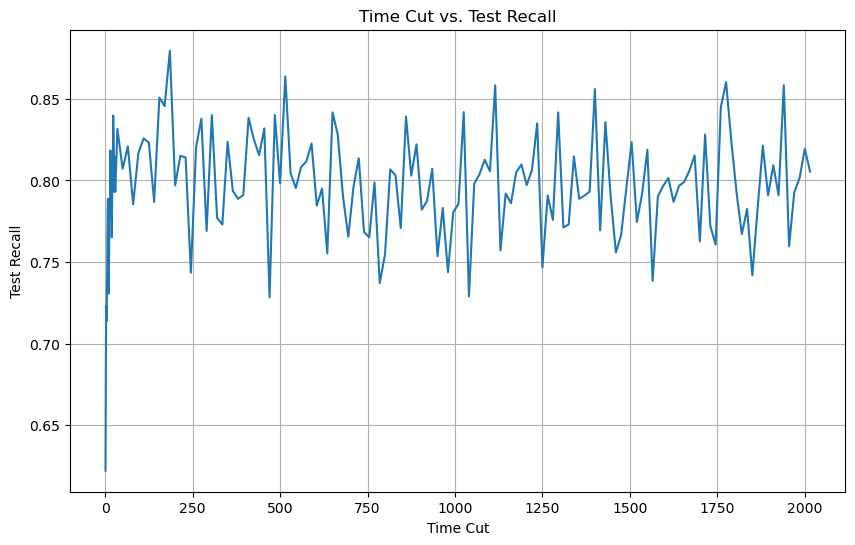

In [4]:
    # Ensure the metrics are numeric
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df=df.sort_values(by='start_time',ascending=True)
df['metrics.time_cut'] = pd.to_numeric(df['metrics.time_cut'], errors='coerce')
df['metrics.test_recall'] = pd.to_numeric(df['metrics.test_recall'], errors='coerce')
    
# Plotting time_cut vs. test_accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(x='metrics.time_cut', y='metrics.test_recall', data=df)
plt.title('Time Cut vs. Test Recall')
plt.xlabel('Time Cut')
plt.ylabel('Test Recall')
plt.grid(True)
plt.show()

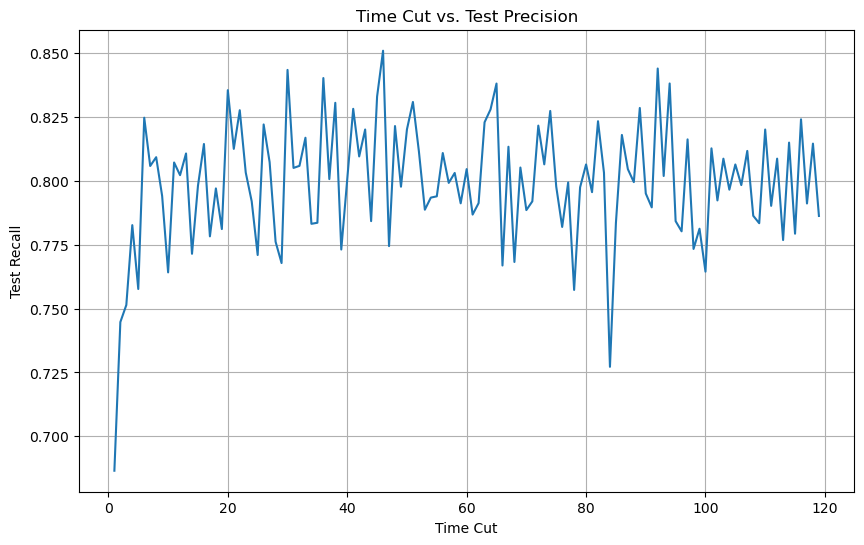

In [24]:
    # Ensure the metrics are numeric
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df=df.sort_values(by='start_time',ascending=True)
df['metrics.time_cut'] = pd.to_numeric(df['metrics.time_cut'], errors='coerce')
df['metrics.test_recall'] = pd.to_numeric(df['metrics.test_precision'], errors='coerce')
    
# Plotting time_cut vs. test_accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(x='metrics.time_cut', y='metrics.test_precision', data=df)
plt.title('Time Cut vs. Test Precision')
plt.xlabel('Time Cut')
plt.ylabel('Test Recall')
plt.grid(True)
plt.show()